<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: West Nile Virus Prediction

### Contents:
- [Background](#Background)
- [Problem Statement](#Problem-Statement)
- [Data Cleaning](#Data-Cleaning)
    - [Train and Test Data](#Train-and-Test-Data) 
    - [Weather Data](#Import-Weather)
    - [Spary Data](#Spray-Data)
- [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
- [Data Preprocessing](#Data-Preprocessing)
- [Data Modeling](#Data-Modeling)
    - [Baseline Model](#Baseline-Model)
        - [Find Best Regression](#Finding-Best-Regression-Model:-Predict-nummosquitos)
        - [Find Best Classification](#Finding-best-classification-Model:-Predicet-wnvpresent)
    - [Building Models](#Building-Models)
        - [Model 1](#Model1:-RandomForestRegressor-+-GradientBoostingClassifier)
        - [Model 2](#Model-2:-Use-only-features-in-train-datasets)
        - [Model 3](#Model-3:-try-to-improve-model-2-with-some-additional-features)
    - [Tuning Hyperparameter](#Tuning-Hyperparameter)
        - [Model 4](#Model-4:-Using-hyperparameter)
- [Result and Discussion](#Result-and-Discussion)
- [Summary of Analysis](#Summary-of-Analysis)
- [Conclusion and Recommendation](#Conclusion-and-Recommendation)

# Background

**What is West Nile Virus**
West Nile Virus (WNV) is the leading cause of mosquito-borne disease in the continental United States.  It is most commonly spread to people by the bite of an infected mosquito. Cases of WNV occur during mosquito season, which starts in the summer and continues through fall. There are no vaccines to prevent or medications to treat WNV in people. Fortunately, most people infected with WNV do not feel sick. About 1 in 5 people who are infected develop a fever and other symptoms. About 1 out of 150 infected people develop a serious, sometimes fatal, illness. You can reduce your risk of WNV by using insect repellent and wearing long-sleeved shirts and long pants to prevent mosquito bites.

<p align="center">
<img src="images/wnvcycle.PNG" width="800" />
</p>

**West Nile Virus in Chicago**

CHICAGO – The Chicago Department of Public Health (CDPH) is reporting 6 cases of West Nile virus infection this year among Chicago residents, following CDC confirmatory testing performed for the first case. All patients developed symptoms between August 15-September 5 and were hospitalized. No deaths have been reported. The age range is 43-75 years (median 57), 3 are female, and 4 are White and 2 are Hispanic. One individual reports traveling out of state during their potential exposure period. The individuals reside in the North, West and East regions of the City. For the 2019 season, CDPH reported 6 human cases, including 1 death.
West Nile virus is transmitted through the bite of a Culex pipiens mosquito, commonly called a house mosquito, which has picked up the virus by feeding on an infected bird. Common symptoms include fever, nausea, headache and muscle aches. Symptoms may last from a few days to a few weeks. However, four out of five people infected with West Nile virus will not show any symptoms. In rare cases, severe illness including meningitis, or even death, can occur. People older than 60 and individuals with weakened immune systems are at higher risk for severe illness from West Nile virus and need to remain vigilant.
Each year CDPH conducts a comprehensive mosquito surveillance program, which includes placing larvicide in catch basins to limit the number of mosquitoes that can carry the virus, and trapping mosquitoes throughout the city and testing them for West Nile virus. By using data, the City is able to most efficiently target high-risk areas for the virus and keep residents safe.


# Problem Statement

Predict **when** and **where** different species of mosquitoes will test positive for West Nile virus. A more accurate method of predicting outbreaks of West Nile virus in mosquitoes will help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus.

---------------------------------

In [289]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from datetime import datetime,timedelta
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression,RidgeCV,Ridge,LassoCV,Lasso,ElasticNetCV,ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.svm import SVC,SVR
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.metrics import plot_confusion_matrix,roc_auc_score,plot_roc_curve,recall_score

from sklearn.decomposition import PCA

-----------------------------------------

# Data Cleaning

## Train and Test Data

In [2]:
#import data
train = pd.read_csv('../assets/input/train.csv')
test = pd.read_csv('../assets/input/test.csv')
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [3]:
#look at all the columns
train.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent'],
      dtype='object')

In [4]:
test.columns #contain iD
# not contain NumMosquitos, Wnvpresent -> Target

Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy'],
      dtype='object')

In [5]:
#look at shape of data
train.shape

(10506, 12)

Drop location-related columns to only use lat/long

In [6]:
train = train.drop(columns=['Address','Block','Street','AddressNumberAndStreet'])
train.rename(columns={"Latitude":'lat','Longitude':'long'},inplace=True)
train.columns = train.columns.str.lower()
train.columns

Index(['date', 'species', 'trap', 'lat', 'long', 'addressaccuracy',
       'nummosquitos', 'wnvpresent'],
      dtype='object')

In [7]:
#Same process for rest
test = test.drop(columns=['Address','Block','Street','AddressNumberAndStreet'])
test.rename(columns={"Latitude":'lat','Longitude':'long'},inplace=True)
test.columns = test.columns.str.lower()
test.columns

Index(['id', 'date', 'species', 'trap', 'lat', 'long', 'addressaccuracy'], dtype='object')

combine lat/long to use for calculating distance

In [8]:
def combine_latlong(df):
    """This function accepts dataframe that contains 'lat' and 'long' columns
    and combine into columns called latlong"""
    latlong_list = []
    for i in range(df.shape[0]):
        latlong = (df['lat'][i] , df['long'][i])
        latlong_list.append(latlong)
    df['latlong'] = latlong_list
    return df

In [9]:
train.shape

(10506, 8)

In [10]:
train = combine_latlong(train)
train.head()

,date,species,trap,lat,long,addressaccuracy,nummosquitos,wnvpresent,latlong
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,9,1,0,"(41.95469, -87.800991)"
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,9,1,0,"(41.95469, -87.800991)"
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,9,1,0,"(41.994991, -87.769279)"
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,8,1,0,"(41.974089, -87.824812)"
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,8,4,0,"(41.974089, -87.824812)"


In [11]:
train.shape

(10506, 9)

In [12]:
test.shape

(116293, 7)

In [13]:
test = combine_latlong(test)
test.head()

,id,date,species,trap,lat,long,addressaccuracy,latlong
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,9,"(41.95469, -87.800991)"
1,2,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991,9,"(41.95469, -87.800991)"
2,3,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991,9,"(41.95469, -87.800991)"
3,4,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991,9,"(41.95469, -87.800991)"
4,5,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991,9,"(41.95469, -87.800991)"


In [14]:
test.shape

(116293, 8)

Below is the Station information
- Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT 
    - Lat: 41.995 
    - Lon: -87.933 
    - Elev: 662 ft. above sea level
- Station 2: CHICAGO MIDWAY INTL ARPT 
    - Lat: 41.786 
    - Lon: -87.752 
    - Elev: 612 ft. above sea level
    
Use station's lat/long to calculate distance to each trap

In [15]:
#pip install geopy #install geopy

In [16]:
import geopy.distance  as geo

In [17]:
#define station_1 and station_2 latlong
station_1_latlong = (41.995,-87.933)
station_2_latlong = (41.786,-87.752)

In [18]:
#get location for all trap
trap_location = pd.concat([train[['trap','latlong','lat','long']],test[['trap','latlong','lat','long']]]).drop_duplicates(subset=['trap']).reset_index(drop=True)
trap_location

,trap,latlong,lat,long
0,T002,"(41.95469, -87.800991)",41.954690,-87.800991
1,T007,"(41.994991, -87.769279)",41.994991,-87.769279
2,T015,"(41.974089, -87.824812)",41.974089,-87.824812
3,T045,"(41.9216, -87.666455)",41.921600,-87.666455
4,T046,"(41.891118, -87.65449100000001)",41.891118,-87.654491
...,...,...,...,...
144,T218B,"(41.94828, -87.74134000000001)",41.948280,-87.741340
145,T002A,"(41.965571000000004, -87.78197800000001)",41.965571,-87.781978
146,T002B,"(41.951878, -87.789234)",41.951878,-87.789234
147,T234,"(41.942285, -87.761726)",41.942285,-87.761726


In [19]:
#get station that is closest to the trap
station_list = []
for i in range(trap_location.shape[0]):
    dist_1 = geo.distance(trap_location['latlong'][i], station_1_latlong).km
    dist_2 = geo.distance(trap_location['latlong'][i], station_2_latlong).km
    if dist_1 < dist_2:
        station_list.append(1)
    else:
        station_list.append(2)
trap_location['station'] = station_list
trap_location

,trap,latlong,lat,long,station
0,T002,"(41.95469, -87.800991)",41.954690,-87.800991,1
1,T007,"(41.994991, -87.769279)",41.994991,-87.769279,1
2,T015,"(41.974089, -87.824812)",41.974089,-87.824812,1
3,T045,"(41.9216, -87.666455)",41.921600,-87.666455,2
4,T046,"(41.891118, -87.65449100000001)",41.891118,-87.654491,2
...,...,...,...,...,...
144,T218B,"(41.94828, -87.74134000000001)",41.948280,-87.741340,1
145,T002A,"(41.965571000000004, -87.78197800000001)",41.965571,-87.781978,1
146,T002B,"(41.951878, -87.789234)",41.951878,-87.789234,1
147,T234,"(41.942285, -87.761726)",41.942285,-87.761726,1


In [20]:
#combine station to main dataframe
train = pd.merge(train,trap_location[['trap','station']],on='trap')
test = pd.merge(test,trap_location[['trap','station']],on='trap')
train.head()

,date,species,trap,lat,long,addressaccuracy,nummosquitos,wnvpresent,latlong,station
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,9,1,0,"(41.95469, -87.800991)",1
1,2007-05-29,CULEX RESTUANS,T002,41.95469,-87.800991,9,1,0,"(41.95469, -87.800991)",1
2,2007-06-05,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,9,3,0,"(41.95469, -87.800991)",1
3,2007-06-05,CULEX RESTUANS,T002,41.95469,-87.800991,9,5,0,"(41.95469, -87.800991)",1
4,2007-06-05,CULEX PIPIENS,T002,41.95469,-87.800991,9,1,0,"(41.95469, -87.800991)",1


### Combining rows that reach maximum number of mosquitos (50)

<AxesSubplot:xlabel='nummosquitos', ylabel='Count'>

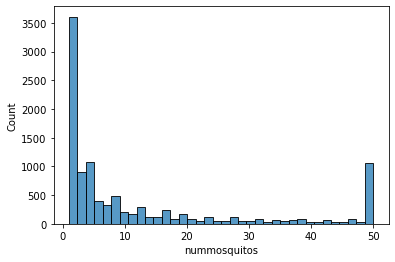

In [21]:
sns.histplot(train.nummosquitos) #maximum is 50 which 

In [22]:
#combining rows that has the same feature except for nummosquitos
train = train.groupby(['date','species','trap','lat','long','latlong','station','addressaccuracy'], as_index=False).sum().reindex()

In [23]:
train['nummosquitos'].value_counts()

1      2113
2      1171
3       803
4       540
5       432
       ... 
467       1
411       1
387       1
527       1
315       1
Name: nummosquitos, Length: 232, dtype: int64

In [24]:
train.nummosquitos.unique()

array([   1,    2,    4,    3,    5,    7,    9,   10,    8,    6,   20,
         19,   25,   16,   28,   11,   12,   29,   18,   39,   51,   22,
         15,  143,   27,   14,   13,  189,   17,   21,   34,   26,   30,
         50,  100,   42,  102,   63,   76,   53,  418,   32, 2356,   55,
        502,  644,   83,  411,   23,   67,   72,   41,   24,   52,   89,
         88, 1543,   36,  477,  104,   82,   31,   46,   65,   69,  223,
         61,  378,  765,  219,   43,  164,  203,   70,   57,   33,  712,
        184,   35,  266,  362,  200,  113,  153,   54,  154,   44,   37,
         45,   56,   62,  110, 1310,  305, 1658,  137,  315,   80,  234,
        115,  118,   79,  138,  157,   90,   38,   49,   98,  108,   86,
        130,  146,  253,   74,   71, 2532,  821, 1000,  651,  174,   60,
        279,  121,  177,   85,  209, 1554,  217,  231, 1054,   40,  230,
         68,  106,  421, 2207,  290,  561,   48,  211,  399,  269,  123,
        127,   75, 1648,   47,  387,  914,  116,  9

In [25]:
train['nummosquitos'].sum()

135039

In [26]:
#wnvpresent also got sum up
train['wnvpresent'].unique()

array([ 0,  1,  3,  2, 10,  7,  6,  4,  9,  8,  5], dtype=int64)

In [27]:
#when wnvpresent > 1, use value 1 instead
train['wnvpresent'] = train['wnvpresent'].apply(lambda x: 1 if x > 0 else 0)
train['wnvpresent'].unique()

array([0, 1], dtype=int64)

## Import Weather

In [28]:
weather = pd.read_csv('../assets/input/weather.csv')
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [29]:
weather.shape

(2944, 22)

In [30]:
weather.columns = weather.columns.str.lower()
weather.columns

Index(['station', 'date', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint',
       'wetbulb', 'heat', 'cool', 'sunrise', 'sunset', 'codesum', 'depth',
       'water1', 'snowfall', 'preciptotal', 'stnpressure', 'sealevel',
       'resultspeed', 'resultdir', 'avgspeed'],
      dtype='object')

In [31]:
weather.dtypes

station          int64
date            object
tmax             int64
tmin             int64
tavg            object
depart          object
dewpoint         int64
wetbulb         object
heat            object
cool            object
sunrise         object
sunset          object
codesum         object
depth           object
water1          object
snowfall        object
preciptotal     object
stnpressure     object
sealevel        object
resultspeed    float64
resultdir        int64
avgspeed        object
dtype: object

### fixing missing value and convert to float dtypes

In [32]:
# 'M' = missing, replace with null
weather.replace('M',np.nan,inplace=True)

In [33]:
#convert to float for columns that has float and nan 
weather.tavg = weather.tavg.astype('float')
weather.depart =  weather.depart.astype('float')
weather.wetbulb = weather.wetbulb.astype('float')
weather.heat = weather.heat.astype('float')
weather.cool = weather.cool.astype('float')
weather.stnpressure = weather.stnpressure.astype('float')
weather.sealevel = weather.sealevel.astype('float')
weather.avgspeed = weather.avgspeed.astype('float')

In [34]:
weather.sunrise.unique()

array(['0448', '-', '0447', '0446', '0444', '0443', '0442', '0441',
       '0439', '0438', '0437', '0436', '0435', '0434', '0433', '0432',
       '0431', '0430', '0429', '0428', '0427', '0426', '0425', '0424',
       '0423', '0422', '0421', '0420', '0419', '0418', '0417', '0416',
       '0440', '0445', '0449', '0450', '0451', '0452', '0453', '0454',
       '0455', '0456', '0457', '0458', '0459', '0500', '0501', '0502',
       '0503', '0504', '0505', '0506', '0508', '0509', '0510', '0511',
       '0512', '0513', '0514', '0515', '0516', '0517', '0518', '0519',
       '0520', '0521', '0522', '0523', '0524', '0525', '0526', '0527',
       '0528', '0529', '0530', '0531', '0532', '0533', '0535', '0536',
       '0537', '0538', '0539', '0540', '0541', '0542', '0543', '0544',
       '0545', '0546', '0547', '0548', '0549', '0550', '0552', '0553',
       '0554', '0555', '0556', '0557', '0558', '0559', '0600', '0602',
       '0603', '0604', '0605', '0606', '0607', '0608', '0610', '0611',
       '0

In [35]:
#replace '-' for sunset and sunrise 
weather.sunrise.replace('-',np.nan,inplace=True)
weather.sunset.replace('-',np.nan,inplace=True)

#convert to float
weather.sunrise = weather.sunrise.astype('float')
weather.sunset = weather.sunset.astype('float')

#replace ' ' to 'Moderate' according to documentation
weather.codesum.replace(' ','Mod',inplace=True)

In [36]:
#check for depth , water 1 , snowfall

In [37]:
weather[weather.depth.isnull()].station.value_counts() #no data on station 2

2    1472
Name: station, dtype: int64

In [38]:
weather.water1.unique() # no data

array([nan])

In [39]:
weather.snowfall.value_counts()

0.0    1459
  T      12
0.1       1
Name: snowfall, dtype: int64

In [40]:
weather[weather.snowfall.isnull()].station.value_counts() #no data on station 2

2    1472
Name: station, dtype: int64

drop ['depth','water1','snowfall'] will be dropped due to no data on station2

In [41]:
#check for unique values
weather.preciptotal.unique()

array(['0.00', '  T', '0.13', '0.02', '0.38', '0.60', '0.14', '0.07',
       '0.11', '0.09', '1.01', '0.28', '0.04', '0.08', '0.01', '0.53',
       '0.19', '0.21', '0.32', '0.39', '0.31', '0.42', '0.27', '0.16',
       '0.58', '0.93', '0.05', '0.34', '0.15', '0.35', nan, '0.40',
       '0.66', '0.30', '0.24', '0.43', '1.55', '0.92', '0.89', '0.17',
       '0.03', '1.43', '0.97', '0.26', '1.31', '0.06', '0.46', '0.29',
       '0.23', '0.41', '0.45', '0.83', '1.33', '0.91', '0.48', '0.37',
       '0.88', '2.35', '1.96', '0.20', '0.25', '0.18', '0.67', '0.36',
       '0.33', '1.28', '0.74', '0.76', '0.71', '0.95', '1.46', '0.12',
       '0.52', '0.64', '0.22', '1.24', '0.72', '0.73', '0.65', '1.61',
       '1.22', '0.50', '1.05', '2.43', '0.59', '2.90', '2.68', '1.23',
       '0.62', '6.64', '3.07', '1.44', '1.75', '0.82', '0.80', '0.86',
       '0.63', '0.55', '1.03', '0.70', '1.73', '1.38', '0.44', '1.14',
       '1.07', '3.97', '0.87', '0.78', '1.12', '0.68', '0.10', '0.61',
       '0.

In [42]:
weather.preciptotal.value_counts() # treat T as 0.05 (0<T<0.1 by definition)

0.00    1577
  T      318
0.01     127
0.02      63
0.03      46
        ... 
2.24       1
1.48       1
1.57       1
2.79       1
1.14       1
Name: preciptotal, Length: 167, dtype: int64

In [43]:
# treat T as 0.05 (0<T<0.1 by definition)
weather.preciptotal.replace('  T',0.05,inplace=True)
weather.preciptotal = weather.preciptotal.astype('float')

In [44]:
weather.isnull().sum()

station           0
date              0
tmax              0
tmin              0
tavg             11
depart         1472
dewpoint          0
wetbulb           4
heat             11
cool             11
sunrise        1472
sunset         1472
codesum           0
depth          1472
water1         2944
snowfall       1472
preciptotal       2
stnpressure       4
sealevel          9
resultspeed       0
resultdir         0
avgspeed          3
dtype: int64

drop depart, sunrise , sunset as well

In [45]:
weather.drop(columns=['depth','water1','snowfall','depart','sunrise','sunset'],inplace=True)

In [46]:
weather.isnull().sum()

station         0
date            0
tmax            0
tmin            0
tavg           11
dewpoint        0
wetbulb         4
heat           11
cool           11
codesum         0
preciptotal     2
stnpressure     4
sealevel        9
resultspeed     0
resultdir       0
avgspeed        3
dtype: int64

In [47]:
#doing backfill for nan value
#first sort index and reset index to separate station 1 from 2 , and sort by date

weather_fix_na = weather.sort_values(['station','date']).reset_index(drop=True)
weather_fix_na

,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,codesum,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2007-05-01,83,50,67.0,51,56.0,0.0,2.0,Mod,0.00,29.10,29.82,1.7,27,9.2
1,1,2007-05-02,59,42,51.0,42,47.0,14.0,0.0,BR,0.00,29.38,30.09,13.0,4,13.4
2,1,2007-05-03,66,46,56.0,40,48.0,9.0,0.0,Mod,0.00,29.39,30.12,11.7,7,11.9
3,1,2007-05-04,66,49,58.0,41,50.0,7.0,0.0,RA,0.05,29.31,30.05,10.4,8,10.8
4,1,2007-05-05,66,53,60.0,38,49.0,5.0,0.0,Mod,0.05,29.40,30.10,11.7,7,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-27,79,54,67.0,52,59.0,0.0,2.0,RA,0.02,29.00,29.67,12.7,19,13.6
2940,2,2014-10-28,66,48,57.0,40,48.0,8.0,0.0,RA,0.03,29.23,29.85,14.0,26,14.6
2941,2,2014-10-29,49,40,45.0,34,42.0,20.0,0.0,Mod,0.00,29.42,30.07,8.5,29,9.0
2942,2,2014-10-30,53,37,45.0,35,42.0,20.0,0.0,RA,0.05,29.41,30.10,5.9,23,6.5


In [48]:
#perform backfill - fill nan value with value from upper row
weather_fix_na = weather_fix_na.fillna(method='bfill')
weather_fix_na.isnull().sum()

station        0
date           0
tmax           0
tmin           0
tavg           0
dewpoint       0
wetbulb        0
heat           0
cool           0
codesum        0
preciptotal    0
stnpressure    0
sealevel       0
resultspeed    0
resultdir      0
avgspeed       0
dtype: int64

In [49]:
#adding t minus 1 day data for weather
weather_t_1 = weather_fix_na.shift().drop(columns=['station','date'])
weather_t_1 = weather_t_1.add_suffix('-1')
weather_t_1 

,tmax-1,tmin-1,tavg-1,dewpoint-1,wetbulb-1,heat-1,cool-1,codesum-1,preciptotal-1,stnpressure-1,sealevel-1,resultspeed-1,resultdir-1,avgspeed-1
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,83.0,50.0,67.0,51.0,56.0,0.0,2.0,Mod,0.00,29.10,29.82,1.7,27.0,9.2
2,59.0,42.0,51.0,42.0,47.0,14.0,0.0,BR,0.00,29.38,30.09,13.0,4.0,13.4
3,66.0,46.0,56.0,40.0,48.0,9.0,0.0,Mod,0.00,29.39,30.12,11.7,7.0,11.9
4,66.0,49.0,58.0,41.0,50.0,7.0,0.0,RA,0.05,29.31,30.05,10.4,8.0,10.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,66.0,44.0,55.0,33.0,45.0,10.0,0.0,Mod,0.00,29.28,29.95,1.6,11.0,5.4
2940,79.0,54.0,67.0,52.0,59.0,0.0,2.0,RA,0.02,29.00,29.67,12.7,19.0,13.6
2941,66.0,48.0,57.0,40.0,48.0,8.0,0.0,RA,0.03,29.23,29.85,14.0,26.0,14.6
2942,49.0,40.0,45.0,34.0,42.0,20.0,0.0,Mod,0.00,29.42,30.07,8.5,29.0,9.0


In [50]:
#adding t minus 2 day data for weather
weather_t_2 = weather_fix_na.shift(2).drop(columns=['station','date'])
weather_t_2 = weather_t_2.add_suffix('-2')
weather_t_2 

,tmax-2,tmin-2,tavg-2,dewpoint-2,wetbulb-2,heat-2,cool-2,codesum-2,preciptotal-2,stnpressure-2,sealevel-2,resultspeed-2,resultdir-2,avgspeed-2
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,83.0,50.0,67.0,51.0,56.0,0.0,2.0,Mod,0.00,29.10,29.82,1.7,27.0,9.2
3,59.0,42.0,51.0,42.0,47.0,14.0,0.0,BR,0.00,29.38,30.09,13.0,4.0,13.4
4,66.0,46.0,56.0,40.0,48.0,9.0,0.0,Mod,0.00,29.39,30.12,11.7,7.0,11.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,75.0,52.0,64.0,41.0,52.0,1.0,0.0,BR HZ,0.00,29.27,29.92,9.7,28.0,10.4
2940,66.0,44.0,55.0,33.0,45.0,10.0,0.0,Mod,0.00,29.28,29.95,1.6,11.0,5.4
2941,79.0,54.0,67.0,52.0,59.0,0.0,2.0,RA,0.02,29.00,29.67,12.7,19.0,13.6
2942,66.0,48.0,57.0,40.0,48.0,8.0,0.0,RA,0.03,29.23,29.85,14.0,26.0,14.6


In [51]:
#concat all together
weather_final = pd.concat([weather_fix_na,weather_t_1,weather_t_2],axis=1)
weather_final.head()

,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,codesum,...,wetbulb-2,heat-2,cool-2,codesum-2,preciptotal-2,stnpressure-2,sealevel-2,resultspeed-2,resultdir-2,avgspeed-2
0,1,2007-05-01,83,50,67.0,51,56.0,0.0,2.0,Mod,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2007-05-02,59,42,51.0,42,47.0,14.0,0.0,BR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2007-05-03,66,46,56.0,40,48.0,9.0,0.0,Mod,...,56.0,0.0,2.0,Mod,0.0,29.10,29.82,1.7,27.0,9.2
3,1,2007-05-04,66,49,58.0,41,50.0,7.0,0.0,RA,...,47.0,14.0,0.0,BR,0.0,29.38,30.09,13.0,4.0,13.4
4,1,2007-05-05,66,53,60.0,38,49.0,5.0,0.0,Mod,...,48.0,9.0,0.0,Mod,0.0,29.39,30.12,11.7,7.0,11.9


### Merge weather and train data

In [52]:
train_weather = pd.merge(train,weather_final,on=['station','date'])
train_weather.head()

,date,species,trap,lat,long,latlong,station,addressaccuracy,nummosquitos,wnvpresent,...,wetbulb-2,heat-2,cool-2,codesum-2,preciptotal-2,stnpressure-2,sealevel-2,resultspeed-2,resultdir-2,avgspeed-2
0,2007-05-29,CULEX PIPIENS,T096,41.731922,-87.677512,"(41.731922, -87.677512)",2,8,1,0,...,57.0,0.0,2.0,RA BR,0.08,29.41,30.05,8.2,24.0,9.2
1,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,"(41.867108, -87.654224)",2,8,1,0,...,57.0,0.0,2.0,RA BR,0.08,29.41,30.05,8.2,24.0,9.2
2,2007-05-29,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,"(41.919343, -87.694259)",2,8,1,0,...,57.0,0.0,2.0,RA BR,0.08,29.41,30.05,8.2,24.0,9.2
3,2007-05-29,CULEX PIPIENS/RESTUANS,T054,41.921965,-87.632085,"(41.921965, -87.632085)",2,8,2,0,...,57.0,0.0,2.0,RA BR,0.08,29.41,30.05,8.2,24.0,9.2
4,2007-05-29,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,"(41.688324, -87.676709)",2,8,1,0,...,57.0,0.0,2.0,RA BR,0.08,29.41,30.05,8.2,24.0,9.2


In [53]:
train_weather.shape

(8475, 52)

In [54]:
train_weather.dtypes

date                object
species             object
trap                object
lat                float64
long               float64
latlong             object
station              int64
addressaccuracy      int64
nummosquitos         int64
wnvpresent           int64
tmax                 int64
tmin                 int64
tavg               float64
dewpoint             int64
wetbulb            float64
heat               float64
cool               float64
codesum             object
preciptotal        float64
stnpressure        float64
sealevel           float64
resultspeed        float64
resultdir            int64
avgspeed           float64
tmax-1             float64
tmin-1             float64
tavg-1             float64
dewpoint-1         float64
wetbulb-1          float64
heat-1             float64
cool-1             float64
codesum-1           object
preciptotal-1      float64
stnpressure-1      float64
sealevel-1         float64
resultspeed-1      float64
resultdir-1        float64
a

In [55]:
train_weather.isnull().sum()

date               0
species            0
trap               0
lat                0
long               0
latlong            0
station            0
addressaccuracy    0
nummosquitos       0
wnvpresent         0
tmax               0
tmin               0
tavg               0
dewpoint           0
wetbulb            0
heat               0
cool               0
codesum            0
preciptotal        0
stnpressure        0
sealevel           0
resultspeed        0
resultdir          0
avgspeed           0
tmax-1             0
tmin-1             0
tavg-1             0
dewpoint-1         0
wetbulb-1          0
heat-1             0
cool-1             0
codesum-1          0
preciptotal-1      0
stnpressure-1      0
sealevel-1         0
resultspeed-1      0
resultdir-1        0
avgspeed-1         0
tmax-2             0
tmin-2             0
tavg-2             0
dewpoint-2         0
wetbulb-2          0
heat-2             0
cool-2             0
codesum-2          0
preciptotal-2      0
stnpressure-2

### Prepare test data with the same process as train data

In [56]:
test.shape

(116293, 9)

In [57]:
test.head()

,id,date,species,trap,lat,long,addressaccuracy,latlong,station
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,9,"(41.95469, -87.800991)",1
1,2,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991,9,"(41.95469, -87.800991)",1
2,3,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991,9,"(41.95469, -87.800991)",1
3,4,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991,9,"(41.95469, -87.800991)",1
4,5,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991,9,"(41.95469, -87.800991)",1


In [58]:
weather_final.head()

,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,codesum,...,wetbulb-2,heat-2,cool-2,codesum-2,preciptotal-2,stnpressure-2,sealevel-2,resultspeed-2,resultdir-2,avgspeed-2
0,1,2007-05-01,83,50,67.0,51,56.0,0.0,2.0,Mod,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2007-05-02,59,42,51.0,42,47.0,14.0,0.0,BR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2007-05-03,66,46,56.0,40,48.0,9.0,0.0,Mod,...,56.0,0.0,2.0,Mod,0.0,29.10,29.82,1.7,27.0,9.2
3,1,2007-05-04,66,49,58.0,41,50.0,7.0,0.0,RA,...,47.0,14.0,0.0,BR,0.0,29.38,30.09,13.0,4.0,13.4
4,1,2007-05-05,66,53,60.0,38,49.0,5.0,0.0,Mod,...,48.0,9.0,0.0,Mod,0.0,29.39,30.12,11.7,7.0,11.9


In [59]:
#Merge with weather
test_weather = pd.merge(test,weather_final,on=['station','date'],how='left')

In [60]:
test_weather.shape

(116293, 51)

In [61]:
#check for null value on test set
test_weather.isnull().sum()

id                 0
date               0
species            0
trap               0
lat                0
long               0
addressaccuracy    0
latlong            0
station            0
tmax               0
tmin               0
tavg               0
dewpoint           0
wetbulb            0
heat               0
cool               0
codesum            0
preciptotal        0
stnpressure        0
sealevel           0
resultspeed        0
resultdir          0
avgspeed           0
tmax-1             0
tmin-1             0
tavg-1             0
dewpoint-1         0
wetbulb-1          0
heat-1             0
cool-1             0
codesum-1          0
preciptotal-1      0
stnpressure-1      0
sealevel-1         0
resultspeed-1      0
resultdir-1        0
avgspeed-1         0
tmax-2             0
tmin-2             0
tavg-2             0
dewpoint-2         0
wetbulb-2          0
heat-2             0
cool-2             0
codesum-2          0
preciptotal-2      0
stnpressure-2      0
sealevel-2   

## Spray Data

In [62]:
spray = pd.read_csv('../assets/input/spray.csv')
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [63]:
#change columns name
spray.columns = spray.columns.str.lower()
spray.rename(columns={'latitude':'lat','longitude':'long'},inplace=True)
#convert to datetime
spray.date = pd.to_datetime(spray.date)

spray.head()

,date,time,lat,long
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [64]:
#create latlong_spray column which combine lat and long
spray = combine_latlong(spray)
spray

,date,time,lat,long,latlong
0,2011-08-29,6:56:58 PM,42.391623,-88.089163,"(42.3916233333333, -88.0891633333333)"
1,2011-08-29,6:57:08 PM,42.391348,-88.089163,"(42.3913483333333, -88.0891633333333)"
2,2011-08-29,6:57:18 PM,42.391022,-88.089157,"(42.3910216666667, -88.0891566666667)"
3,2011-08-29,6:57:28 PM,42.390637,-88.089158,"(42.3906366666667, -88.0891583333333)"
4,2011-08-29,6:57:38 PM,42.390410,-88.088858,"(42.390409999999996, -88.0888583333333)"
...,...,...,...,...,...
14830,2013-09-05,8:34:11 PM,42.006587,-87.812355,"(42.006586666666706, -87.81235500000001)"
14831,2013-09-05,8:35:01 PM,42.006192,-87.816015,"(42.0061916666667, -87.81601500000001)"
14832,2013-09-05,8:35:21 PM,42.006022,-87.817392,"(42.006021666666705, -87.8173916666667)"
14833,2013-09-05,8:35:31 PM,42.005453,-87.817423,"(42.0054533333333, -87.8174233333333)"


In [65]:
#look at how much each days the spray was done
spray.groupby('date')['latlong'].count() #spray on ten day

date
2011-08-29      95
2011-09-07    2114
2013-07-17    2202
2013-07-25    1607
2013-08-08    1195
2013-08-15    2668
2013-08-16     141
2013-08-22    1587
2013-08-29    2302
2013-09-05     924
Name: latlong, dtype: int64

<AxesSubplot:xlabel='date'>

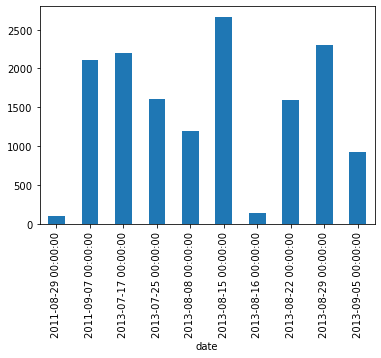

In [66]:
spray.groupby('date')['latlong'].count().plot(kind='bar')

In [67]:
#define new list to store date of spray
spray_date_list = spray.date.unique()
spray_date_list

array(['2011-08-29T00:00:00.000000000', '2011-09-07T00:00:00.000000000',
       '2013-07-17T00:00:00.000000000', '2013-07-25T00:00:00.000000000',
       '2013-08-08T00:00:00.000000000', '2013-08-15T00:00:00.000000000',
       '2013-08-16T00:00:00.000000000', '2013-08-22T00:00:00.000000000',
       '2013-08-29T00:00:00.000000000', '2013-09-05T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [68]:
trap_location

,trap,latlong,lat,long,station
0,T002,"(41.95469, -87.800991)",41.954690,-87.800991,1
1,T007,"(41.994991, -87.769279)",41.994991,-87.769279,1
2,T015,"(41.974089, -87.824812)",41.974089,-87.824812,1
3,T045,"(41.9216, -87.666455)",41.921600,-87.666455,2
4,T046,"(41.891118, -87.65449100000001)",41.891118,-87.654491,2
...,...,...,...,...,...
144,T218B,"(41.94828, -87.74134000000001)",41.948280,-87.741340,1
145,T002A,"(41.965571000000004, -87.78197800000001)",41.965571,-87.781978,1
146,T002B,"(41.951878, -87.789234)",41.951878,-87.789234,1
147,T234,"(41.942285, -87.761726)",41.942285,-87.761726,1


Text(0, 0.5, 'Latitude')

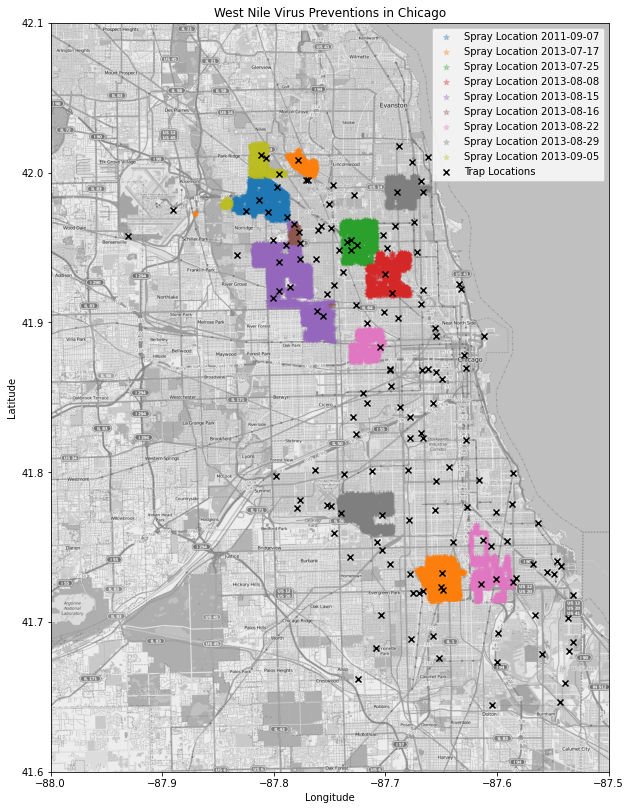

In [69]:
#plot spray location with trap location 
# Load map data
mapdata = np.loadtxt("../assets/input/mapdata_copyright_openstreetmap_contributors.txt")

#define lat lot of map
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

# Plot map
plt.figure(figsize=(10,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)


for i in range(1,len(spray_date_list)):
    label_name = 'Spray Location ' + str(spray_date_list[i])[:10]
    plt.scatter(spray[spray.date == spray_date_list[i]]['long'],spray[spray.date == spray_date_list[i]]['lat'],marker='*', alpha=.3,label=label_name)

#plot trap
plt.scatter(trap_location['long'], trap_location['lat'], marker='x', label='Trap Locations',color='black')


plt.title('West Nile Virus Preventions in Chicago')
plt.legend(frameon=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [70]:
#create new function to get trap that exposed to each spray
def get_spray_trap_dict():
    spray_trap_dict = {}
    #for each day
    for n in tqdm(range(1,len(spray_date_list))):
        trap_list = []
        #for each trap
        for i in range(trap_location.shape[0]):
            #for each spray
            base_distance = 100
            for j in spray[spray.date == spray_date_list[n]].index:
                if base_distance >1:
                    #calculate distance of each trap to each point
                    distance = geo.distance(trap_location.latlong[i],spray.latlong[j]).km
                    #if distance < 1km, store trap in traplist
                    if distance<=1:
                        base_distance = distance
                        trap_list.append(trap_location.trap[i])
        #store in dict
        spray_trap_dict[spray_date_list[n]] = trap_list
    return spray_trap_dict

In [71]:
#this takes time to complete

#spray_trap_dict = get_spray_trap_dict()
#spray_trap['date'] = spray_trap_dict.keys()
#spray_trap['trap_list'] = spray_trap_dict.values()
#spray_trap.to_csv('spray_trap_list.csv',index=False)

In [72]:
spray_trap = pd.read_csv('spray_trap_list.csv') #read from file instead
spray_trap

,date,trap_list
0,2011-09-07,"['T015', 'T143', 'T009', 'T006', 'T014', 'T223..."
1,2013-07-17,"['T007', 'T094', 'T096', 'T159', 'T089', 'T008..."
2,2013-07-25,"['T019', 'T146', 'T218', 'T001', 'T004', 'T228..."
3,2013-08-08,"['T045', 'T050', 'T019', 'T147', 'T224']"
4,2013-08-15,"['T002', 'T153', 'T142', 'T151', 'T154', 'T037..."
5,2013-08-16,"['T142', 'T154', 'T014', 'T017', 'T230', 'T002..."
6,2013-08-22,"['T162', 'T030', 'T044', 'T080', 'T138', 'T107..."
7,2013-08-29,"['T028', 'T149', 'T065', 'T066', 'T156', 'T035..."
8,2013-09-05,"['T143', 'T016', 'T006', 'T233']"


#### Check spray performance by look at the event of the spray for the exposed trap


In [73]:
#create function to convert string to list
def string_to_list(text):
    return [x.strip().strip('\'') for x in text.strip('[]').split(',')]

In [74]:
#apply function
spray_trap.trap_list = spray_trap.trap_list.apply(lambda x:string_to_list(x))

In [75]:
#convery date to datetime
spray_trap.date = pd.to_datetime(spray_trap.date)
train_weather.date = pd.to_datetime(train_weather.date)
spray_trap.dtypes

date         datetime64[ns]
trap_list            object
dtype: object

In [76]:
#try working on day 1 of spray | using range of +- 90days 
spray_1 = train_weather[(train_weather.date >=(spray_trap.date[0] - timedelta(days=90)))&(train_weather.date <= (spray_trap.date[0] + timedelta(days=90)))][['date','trap','nummosquitos','wnvpresent']]
spray_1

,date,trap,nummosquitos,wnvpresent
4690,2011-06-10,T900,7,0
4691,2011-06-10,T903,1,0
4692,2011-06-10,T003,3,0
4693,2011-06-10,T013,1,0
4694,2011-06-10,T028,1,0
...,...,...,...,...
6458,2011-09-30,T145,2,0
6459,2011-09-30,T155,1,0
6460,2011-09-30,T222,1,0
6461,2011-09-30,T227,1,0


In [77]:
#filter only exposed trap
spray_1 = spray_1[spray_1.trap.isin(spray_trap.trap_list[0])]
spray_1

,date,trap,nummosquitos,wnvpresent
4696,2011-06-10,T223,2,0
4805,2011-06-17,T009,9,0
4816,2011-06-17,T009,4,0
4826,2011-06-17,T223,33,0
4835,2011-06-24,T009,1,0
4987,2011-06-30,T009,3,0
5010,2011-07-11,T009,3,0
5017,2011-07-11,T223,22,0
5025,2011-07-11,T009,3,0
5034,2011-07-11,T223,41,0


In [78]:
spray_1_to_plot = spray_1.groupby('date')[['nummosquitos','wnvpresent']].sum()
spray_1_to_plot

,nummosquitos,wnvpresent
date,,
2011-06-10,2,0
2011-06-17,46,0
2011-06-24,1,0
2011-06-30,3,0
2011-07-11,69,0
2011-07-15,130,0
2011-07-25,271,0
2011-07-29,94,1
2011-08-05,123,0


Text(0.5, 1.0, 'No. of Mosquitoes in traps exposed to spray in 2011-09-07')

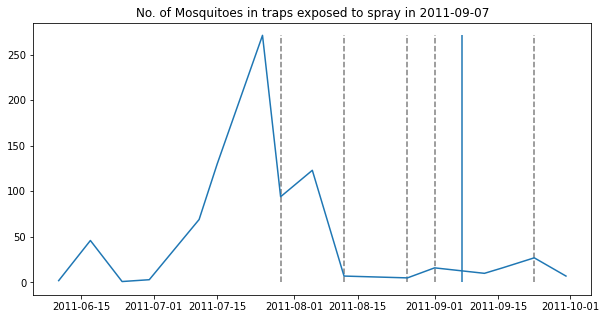

In [79]:
#plot graph
plt.figure(figsize=(10,5))
plt.plot(spray_1_to_plot.nummosquitos,label ='Number of mosquitos')
plt.vlines(x=spray_trap.date[0],ymin=0,ymax=spray_1_to_plot.nummosquitos.max(),label ='spray')
label = True
for date in spray_1_to_plot[spray_1_to_plot.wnvpresent!=0].index:
    if label:
        plt.vlines(x=date,ymin=0,ymax=spray_1_to_plot.nummosquitos.max(),linestyles='dashed',label='wnv present',color='gray')
        label=False
    else:
        plt.vlines(x=date,ymin=0,ymax=spray_1_to_plot.nummosquitos.max(),linestyles='dashed',color='gray')
title = 'No. of Mosquitoes in traps exposed to spray in '+ str(spray_trap.date[0])[:10]
plt.title(title)

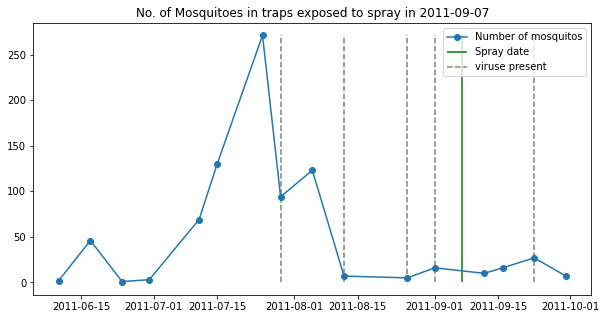

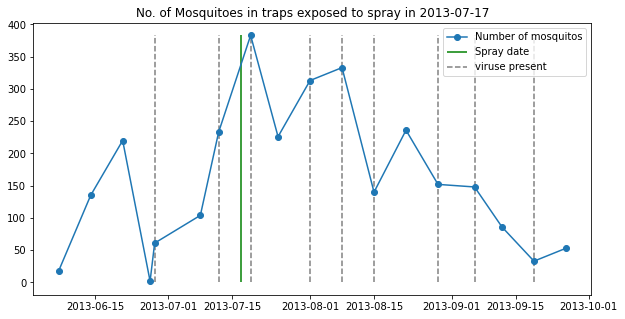

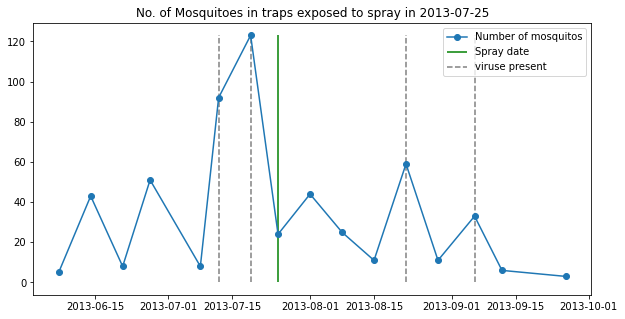

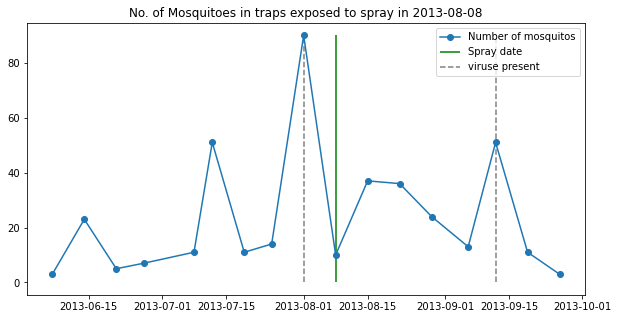

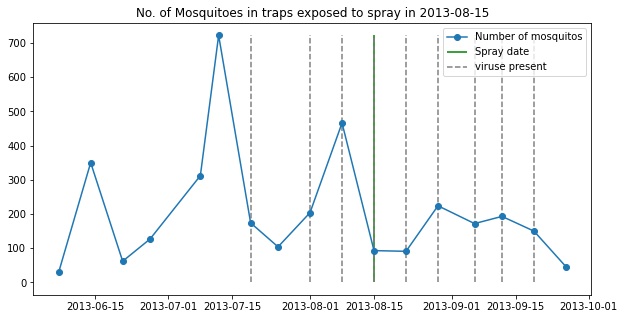

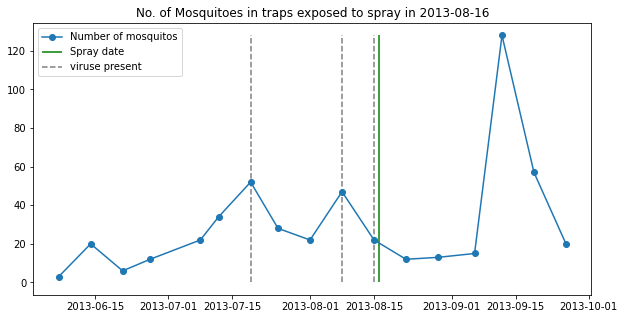

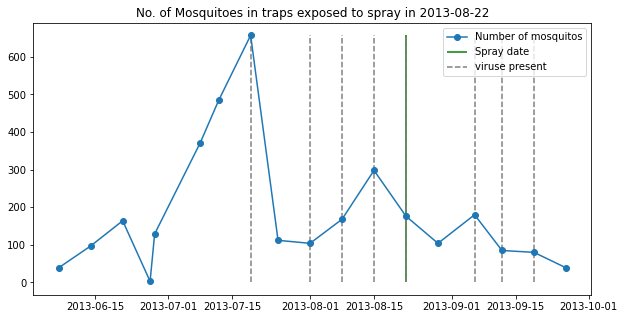

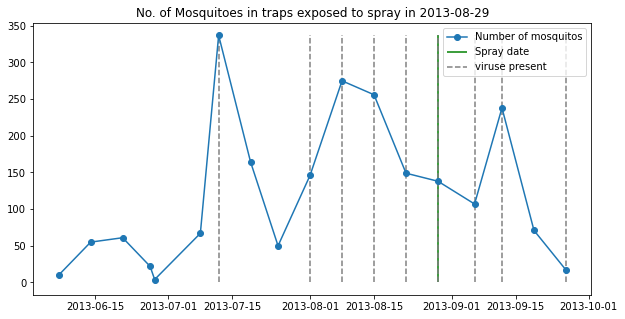

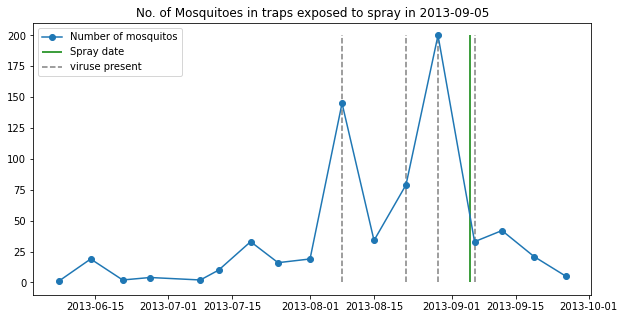

In [80]:
#plot all spray days
for i in range(spray_trap.shape[0]):
    to_plot = train_weather[(train_weather.date >=(spray_trap.date[i] - timedelta(days=90)))&(train_weather.date <= (spray_trap.date[i] + timedelta(days=90)))][['date','trap','nummosquitos','wnvpresent']]
    to_plot = to_plot[to_plot.trap.isin(spray_trap.trap_list[i])]
    to_plot = to_plot.groupby('date')[['nummosquitos','wnvpresent']].sum()
    plt.figure(figsize=(10,5))
    plt.plot(to_plot.nummosquitos,label ='Number of mosquitos',marker ='o')
    plt.vlines(x=spray_trap.date[i],ymin=0,ymax=to_plot.nummosquitos.max(),label ='Spray date',color='green')
    label = True
    for date in to_plot[to_plot.wnvpresent!=0].index:
        if label:
            plt.vlines(x=date,ymin=0,ymax=to_plot.nummosquitos.max(),linestyles='dashed',label='viruse present',color='gray')
            label=False
        else:
            plt.vlines(x=date,ymin=0,ymax=to_plot.nummosquitos.max(),linestyles='dashed',color='gray')
    plt.legend()
    title = 'No. of Mosquitoes in traps exposed to spray in '+ str(spray_trap.date[i])[:10]
    plt.title(title)

The result of spray did not eradicate the presence of virus but only to reduce the number of mosquitos in the area. Also the result did did not last long.

------------------

# Exploratory Data Analysis (EDA)

**Divide features into feature groups**

1. Location Features 
    - Address (Drop)
    - Block (Drop)
    - Street (Drop)
    - Trap
    - AddressNumberAndStreet (Drop)
    - Latitude
    - Longitude
    - AddressAccuracy
2. Mosquitos
    - Species
    - NumMosquitos
    - Trap
3. Temperature
    - Tmax
    - Tmin
    - Depart (Drop)
    - Heat
    - Cool
4. Moisture Presence
    - DewPoint
    - WetBulb
5. Weather
- 5.1 Climatic Condition
    - CodeSum
- 5.2 Snow
    - Depth (drop)
    - Water1 (drop)
    - SnowFall (drop)
- 5.3 Precipitation
    - PrecipTotal
- 5.4 Pressure
    - StationPressure
    - SeaLevel
- 5.5 Wind
    - ResultSpeed
    - ResultDir
    - AvgSpeed

Check target class distribution

C:\Users\Dip\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


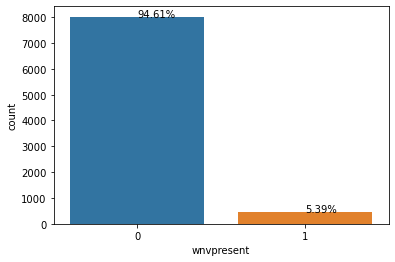

In [81]:
fig,  ax = plt.subplots(1,1)
sns.countplot(train['wnvpresent'], ax = ax)
for i in ax.patches:
    height = i.get_height()
    ax.text(i.get_x()+i.get_width()/2,height,'{:.2f}{}'.format(height/len(train)*100,'%'))
plt.show()

Data is highly imbalanced.

Check number of mosquito and wnvpresent

In [82]:
train[['species','nummosquitos','wnvpresent']].groupby(by='species').sum()

,nummosquitos,wnvpresent
species,,
CULEX ERRATICUS,7,0
CULEX PIPIENS,44671,184
CULEX PIPIENS/RESTUANS,66268,225
CULEX RESTUANS,23431,48
CULEX SALINARIUS,145,0
CULEX TARSALIS,7,0
CULEX TERRITANS,510,0


C:\Users\Dip\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


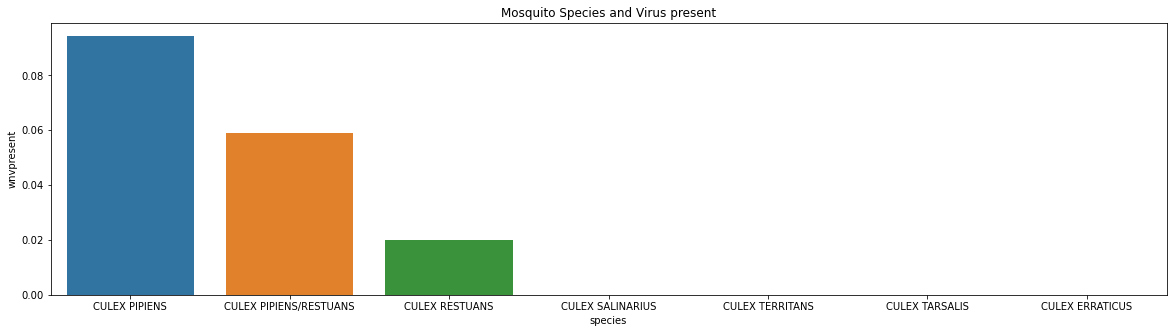

In [83]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
sns.barplot(train_weather['species'],train_weather['wnvpresent'], ax=ax, ci=None)
ax.set_title('Mosquito Species and Virus present')
plt.show()

CULEX PIPIENS and CULEX RESTUANS are the species that most likely be carriers of the west nile virus.

How many Traps?

In [84]:
print(f'Total traps = ' , train['trap'].nunique())

Total traps =  136


Where traps were?

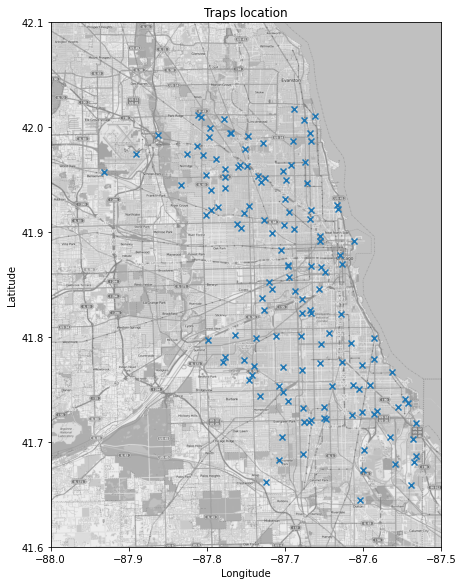

In [85]:
mapdata = np.loadtxt('../assets/input/mapdata_copyright_openstreetmap_contributors.txt')
traps = pd.read_csv('../assets/input/train.csv')[['Date','Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(7,10))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x')

plt.title('Traps location')
#plt.legend(frameon=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude');

Virus spread in 2007, 2009, 2011, 2013


Add year to dataframe

In [86]:
train_weather['date'] = pd.to_datetime(train_weather['date'])
train_weather.reset_index(drop=True,inplace=True)
train_weather.set_index('date',inplace=True)
train_weather['year'] = train_weather.index.year

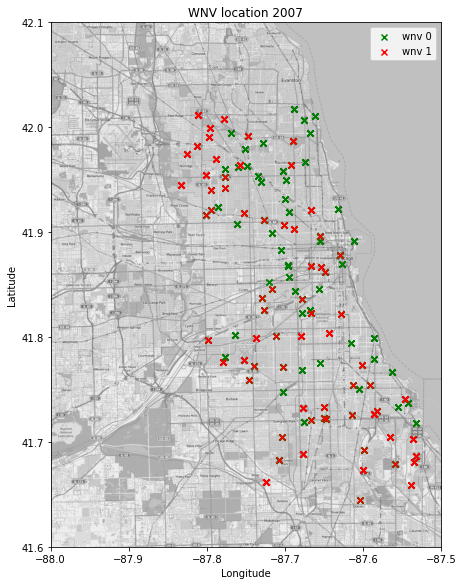

In [87]:
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(7,10))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2007_wnv0 = train_weather[(train_weather['wnvpresent']==0)&(train_weather['year']==2007)]
locations_2007_wnv1 = train_weather[(train_weather['wnvpresent']==1)&(train_weather['year']==2007)]
plt.scatter(locations_2007_wnv0['long'], locations_2007_wnv0['lat'], marker='x', color = 'green', label='wnv 0')
plt.scatter(locations_2007_wnv1['long'], locations_2007_wnv1['lat'], marker='x', color = 'red', label='wnv 1')

plt.title('WNV location 2007')
plt.legend(frameon=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude');


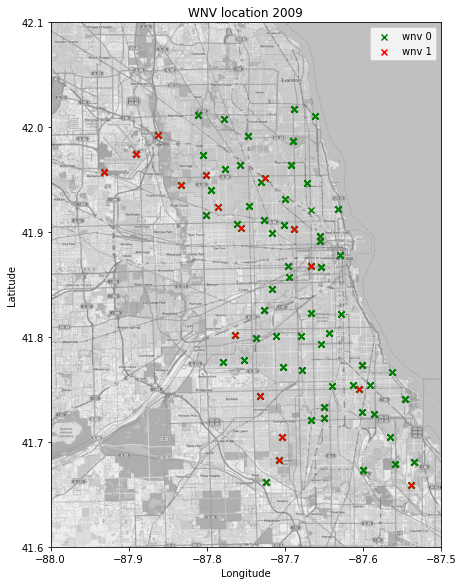

In [88]:
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(7,10))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2009_wnv0 = train_weather[(train_weather['wnvpresent']==0)&(train_weather['year']==2009)]
locations_2009_wnv1 = train_weather[(train_weather['wnvpresent']==1)&(train_weather['year']==2009)]
plt.scatter(locations_2009_wnv0['long'], locations_2009_wnv0['lat'], marker='x', color = 'green', label='wnv 0')
plt.scatter(locations_2009_wnv1['long'], locations_2009_wnv1['lat'], marker='x', color = 'red', label='wnv 1')

plt.title('WNV location 2009')
plt.legend(frameon=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude');

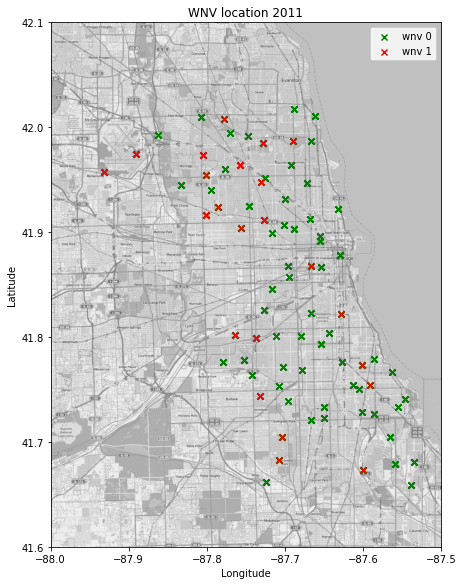

In [89]:
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(7,10))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2011_wnv0 = train_weather[(train_weather['wnvpresent']==0)&(train_weather['year']==2011)]
locations_2011_wnv1 = train_weather[(train_weather['wnvpresent']==1)&(train_weather['year']==2011)]
plt.scatter(locations_2011_wnv0['long'], locations_2011_wnv0['lat'], marker='x', color = 'green', label='wnv 0')
plt.scatter(locations_2011_wnv1['long'], locations_2011_wnv1['lat'], marker='x', color = 'red', label='wnv 1')

plt.title('WNV location 2011')
plt.legend(frameon=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude');

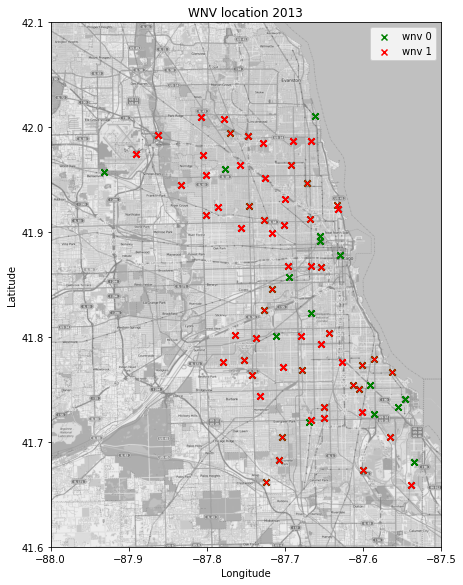

In [90]:
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(7,10))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2013_wnv0 = train_weather[(train_weather['wnvpresent']==0)&(train_weather['year']==2013)]
locations_2013_wnv1 = train_weather[(train_weather['wnvpresent']==1)&(train_weather['year']==2013)]
plt.scatter(locations_2013_wnv0['long'], locations_2013_wnv0['lat'], marker='x', color = 'green', label='wnv 0')
plt.scatter(locations_2013_wnv1['long'], locations_2013_wnv1['lat'], marker='x', color = 'red', label='wnv 1')

plt.title('WNV location 2013')
plt.legend(frameon=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude');

Virus were more spreaded in 2007, 2013.

Bar plot : number of Virus present and year

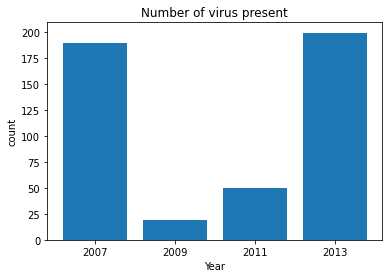

In [91]:
#figure(figsize = (7,9))
height_2007 = train_weather[(train_weather['wnvpresent']==1)&(train_weather['year']==2007)].shape[0]
height_2009 = train_weather[(train_weather['wnvpresent']==1)&(train_weather['year']==2009)].shape[0]
height_2011 = train_weather[(train_weather['wnvpresent']==1)&(train_weather['year']==2011)].shape[0]
height_2013 = train_weather[(train_weather['wnvpresent']==1)&(train_weather['year']==2013)].shape[0]
height = [height_2007,height_2009,height_2011,height_2013]
x = ['2007','2009','2011','2013']
plt.bar(data = train_weather, x = x, height = height)
plt.title('Number of virus present')
plt.xlabel('Year')
plt.ylabel('count')
plt.show()

#### Effect of Temperatue.

Plot average temperature of each year.

C:\Users\Dip\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Dip\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Dip\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (

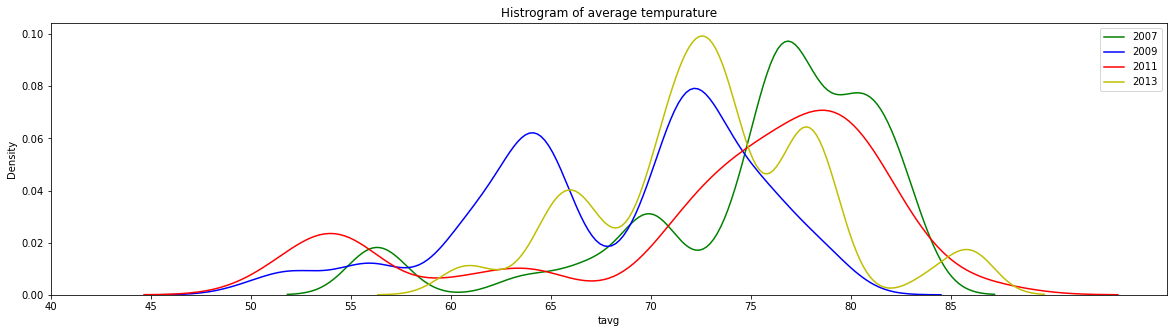

In [92]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
sns.distplot(train_weather.loc[train_weather.index.year==2007,'tavg'], ax=ax,color='g',hist=False, label='2007')
sns.distplot(train_weather.loc[train_weather.index.year==2009,'tavg'], ax=ax,color='b',hist=False, label='2009')
sns.distplot(train_weather.loc[train_weather.index.year==2011,'tavg'], ax=ax,color='r',hist=False, label='2011')
sns.distplot(train_weather.loc[train_weather.index.year==2013,'tavg'], ax=ax,color='y',hist=False, label='2013')
ax.xaxis.set(ticks=np.arange(40,90,5))
ax.set_title('Histrogram of average tempurature')

plt.legend(frameon=1)
plt.show()

From the above there are 4 peaks we see in the average temperature distribution was due to high temperatures in different years.

1. 2007(green) - The mean of average temp was between 75-80.
2. 2009(blue) - The mean of average temp was between 65-70 and the peak hike was attained during 70-75 range.
3. 2011(red) - The mean of average temp was 75 but we could notice a small bump in the early 50-55 range as well.
4. 2013(yellow) - The max hike was obtained during 70-80 range.

We can see that in the year that had high mean of average temperature virus was spread more.

C:\Users\Dip\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


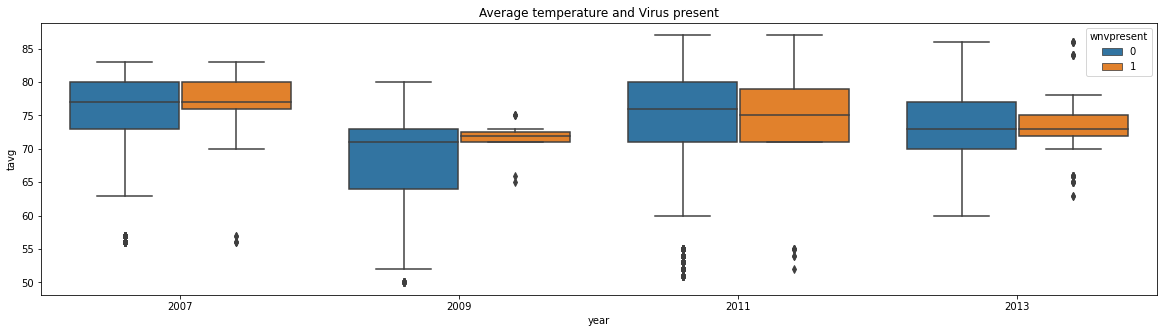

In [93]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
sns.boxplot(train_weather['year'],train_weather['tavg'].apply(int), hue = train_weather['wnvpresent'], ax=ax)
ax.set_title('Average temperature and Virus present')
plt.show()

The above plot shows that the mean temperature is generally higher in the year 2007, 2011 and 2013 when the mosquitos were majorly found to be Wnv carriers.

<AxesSubplot:xlabel='tavg', ylabel='wnvpresent'>

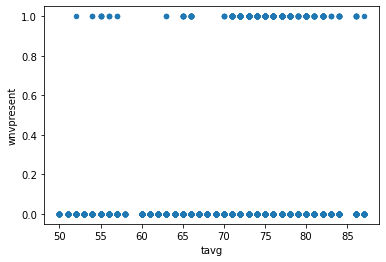

In [94]:
train_weather.plot(kind='scatter',x='tavg',y='wnvpresent')

Eventhough the average temperature didnot impact directly to the presence of virus, the lower the temperature is less likely to have the virus.

#### Effect of moisture presence

Dew Point

In [95]:
train_weather[['year','dewpoint']].dtypes

year        int64
dewpoint    int64
dtype: object

C:\Users\Dip\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


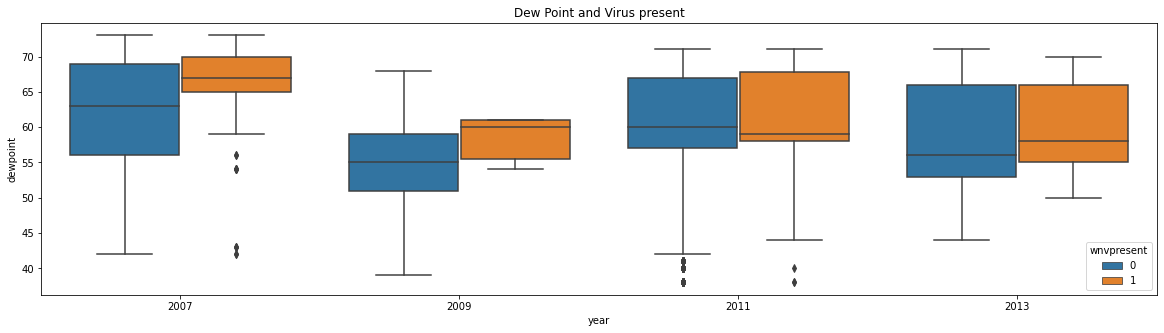

In [96]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
sns.boxplot(train_weather['year'],train_weather['dewpoint'], hue = train_weather['wnvpresent'], ax=ax)
ax.set_title('Dew Point and Virus present')
plt.show()

C:\Users\Dip\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


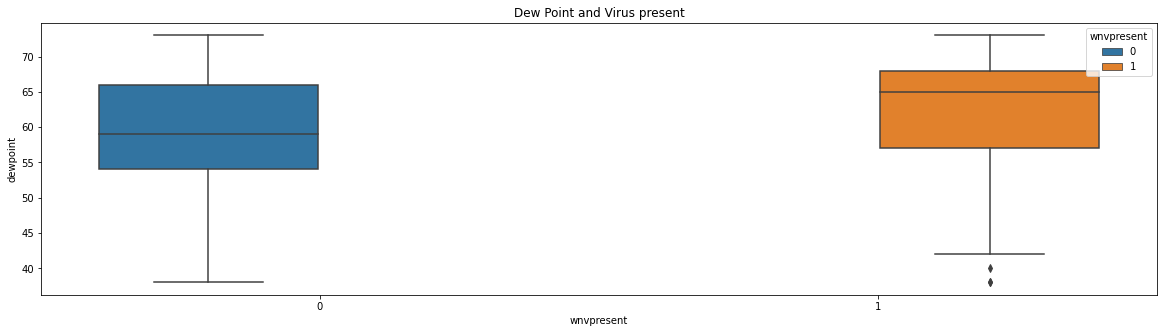

In [97]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
sns.boxplot(train_weather['wnvpresent'],train_weather['dewpoint'], hue = train_weather['wnvpresent'], ax=ax)
ax.set_title('Dew Point and Virus present')
plt.show()

Dewpoint shows the positive correlation to wnvpresent.

C:\Users\Dip\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


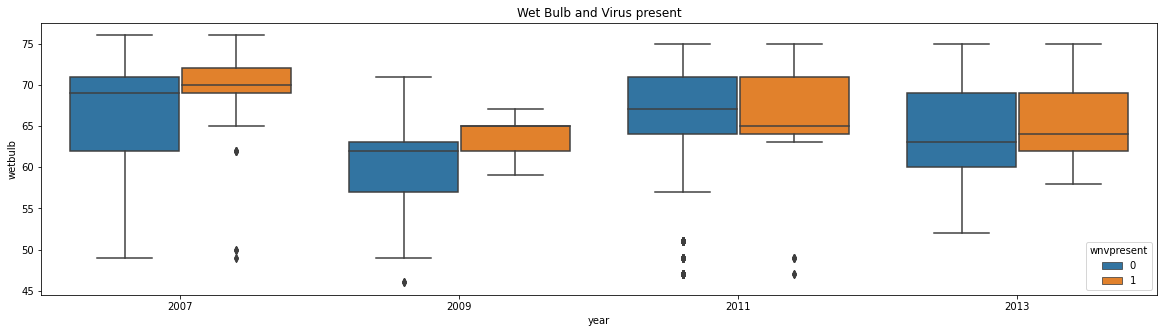

In [98]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
sns.boxplot(train_weather['year'],train_weather['wetbulb'], hue = train_weather['wnvpresent'], ax=ax)
ax.set_title('Wet Bulb and Virus present')
plt.show()

#### Effect of weather Conditions

There are: 28 weather condition


C:\Users\Dip\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Dip\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


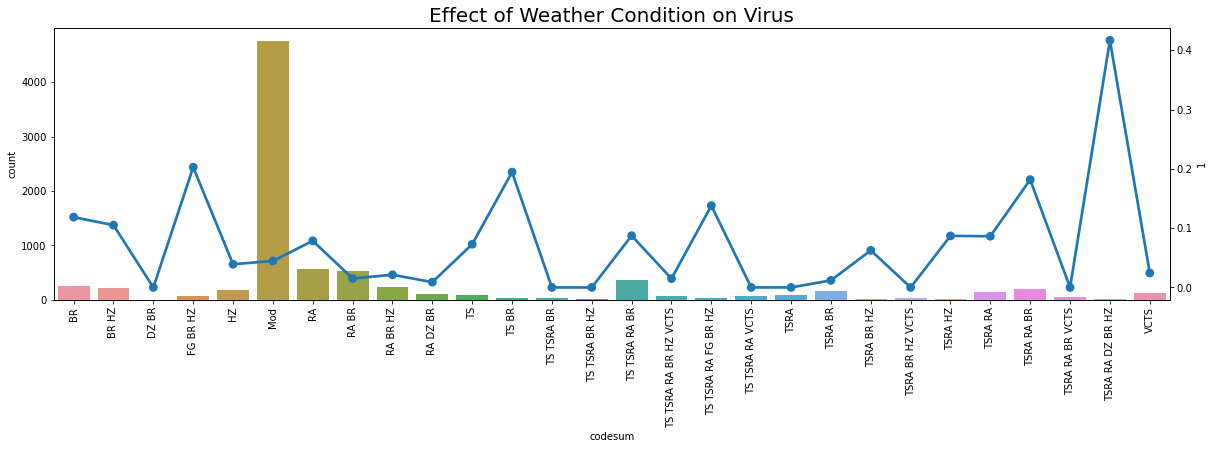

In [99]:
print(f'There are: {train_weather["codesum"].nunique()} weather condition')
fig, ax = plt.subplots(1,1, figsize=(20,5))
tmp = pd.crosstab(train_weather['codesum'],train_weather['wnvpresent'],normalize='index')
tmp.reset_index()

g = sns.countplot(train_weather['codesum'],order = list(tmp.index), ax =ax)
g.tick_params(axis='x',labelrotation=90)
g.set_title('Effect of Weather Condition on Virus', fontsize=20)
g1 = g.twinx()
sns.pointplot(tmp.index,tmp[1], ax=g1)

plt.show()

There are some weather condition that have higher virus present. However, the correlation is not clear.

#### Effect of Precipitation

In [100]:
train_weather.preciptotal = train_weather.preciptotal.astype(float)
train_weather.preciptotal.dtypes

dtype('float64')

In [101]:
train_weather.preciptotal.unique()

array([0.  , 0.42, 0.27, 0.05, 0.16, 1.55, 0.92, 0.01, 0.17, 0.04, 1.31,
       0.06, 0.09, 0.46, 0.23, 0.83, 0.88, 0.24, 0.2 , 0.08, 0.12, 0.87,
       3.97, 0.14, 0.19, 0.03, 0.02, 0.33, 1.19, 0.95, 0.89, 0.59, 0.52,
       0.44, 0.39, 0.13, 0.7 , 0.36, 0.79, 0.11, 0.5 , 0.84, 0.58])

In [102]:
train_weather.wnvpresent.dtypes

dtype('int64')

<AxesSubplot:xlabel='preciptotal', ylabel='wnvpresent'>

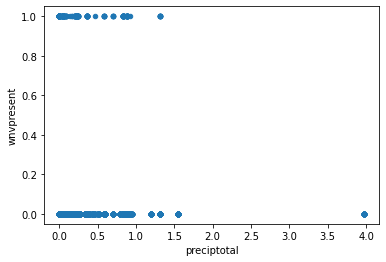

In [103]:
train_weather.plot(kind='scatter',x='preciptotal',y='wnvpresent')

<AxesSubplot:xlabel='wnvpresent', ylabel='preciptotal'>

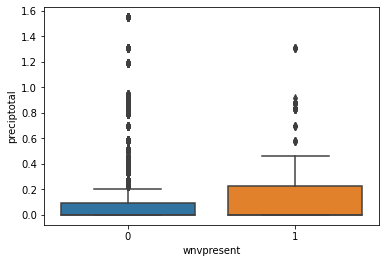

In [104]:
train_weather_precip = train_weather[train_weather.preciptotal<2]
sns.boxplot(data=train_weather_precip,x='wnvpresent',y='preciptotal')

With more rain, virus is more likely to be present.

C:\Users\Dip\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Dip\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


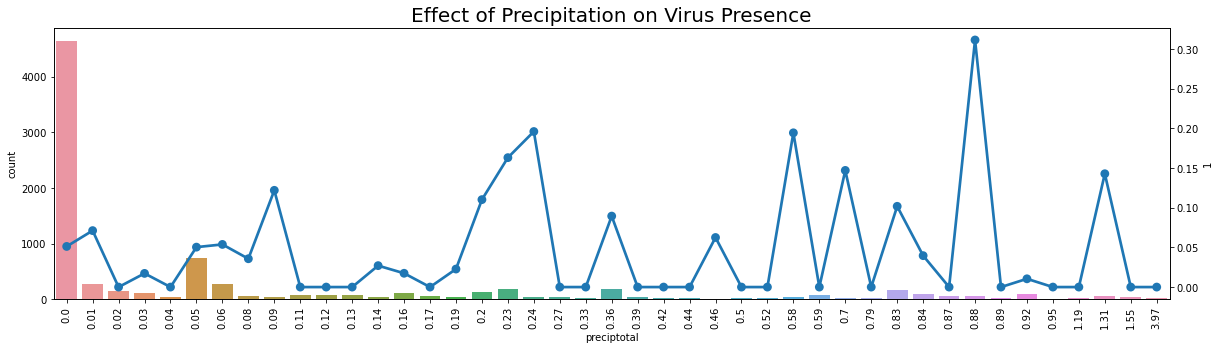

In [105]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
tmp = pd.crosstab(train_weather['preciptotal'],train_weather['wnvpresent'],normalize='index')
tmp.reset_index()

g = sns.countplot(train_weather['preciptotal'],order = list(tmp.index), ax =ax)
g.tick_params(axis='x',labelrotation=90)
g.set_title('Effect of Precipitation on Virus Presence', fontsize=20)
g1 = g.twinx()
sns.pointplot(tmp.index,tmp[1], ax=g1)
plt.show()

Above graph doesn't contain any trends or important informatin.

#### Effect of Stn and Sea Level pressure variables

C:\Users\Dip\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


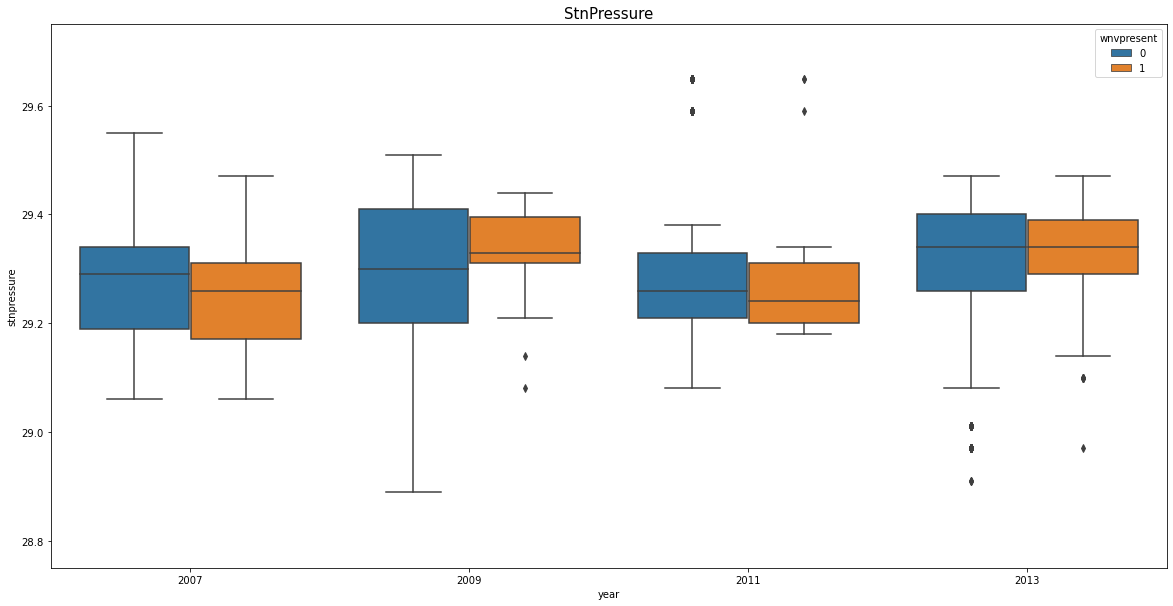

In [106]:
fig, (ax1) = plt.subplots(1,1, figsize=(20,10))
sns.boxplot(train_weather['year'], train_weather['stnpressure'], hue = train_weather['wnvpresent'], ax=ax1)
ax1.set_ylim(28.75,29.75)
ax1.set_title('StnPressure', fontdict= {'fontsize':15})
plt.show()

StnPressure doesn't show any correlation to wnvpresence

Sea Level

C:\Users\Dip\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


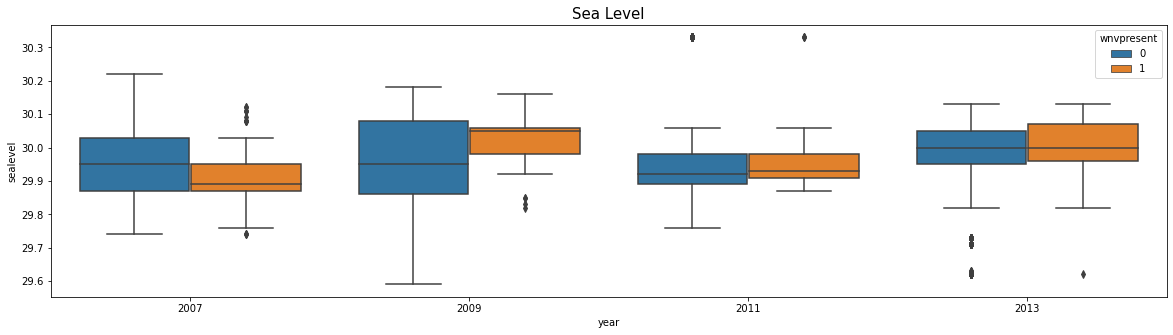

In [107]:
fig, (ax1) = plt.subplots(1,1, figsize=(20,5))
sns.boxplot(train_weather['year'], train_weather['sealevel'], hue = train_weather['wnvpresent'], ax=ax1)
# ax1.set_ylim(28,30)
ax1.set_title('Sea Level', fontdict= {'fontsize':15})
plt.show()

we could not make out any significant inference.

#### Effect  of Wind

Wind speed

C:\Users\Dip\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


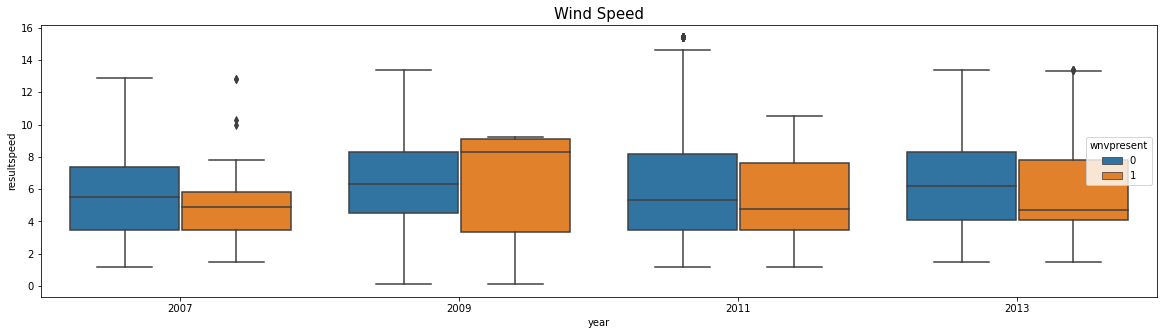

In [108]:
fig, (ax1) = plt.subplots(1,1, figsize=(20,5))
sns.boxplot(train_weather['year'], train_weather['resultspeed'], hue = train_weather['wnvpresent'], ax=ax1)
# ax1.set_ylim(28,30)
ax1.set_title('Wind Speed', fontdict= {'fontsize':15})
plt.show()

Except for 2009, virus has high chance of existence when wind speed is low.

To be conclude, the below is the list of features that show correlation to the presence of West Nile Virus and should be consider use for creating a model.
    
    - species
    - temperature
    - preciptotal
    - dewpoint
    - sealevel
    - windspeed

## EDA on weather data only

In [109]:
weather_to_plot = weather.copy()

In [110]:
weather_to_plot.date = pd.to_datetime(weather_to_plot.date)
weather_to_plot.set_index(weather_to_plot.date,inplace=True)

In [111]:
weather_to_plot.columns

Index(['station', 'date', 'tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb',
       'heat', 'cool', 'codesum', 'preciptotal', 'stnpressure', 'sealevel',
       'resultspeed', 'resultdir', 'avgspeed'],
      dtype='object')

<AxesSubplot:xlabel='date'>

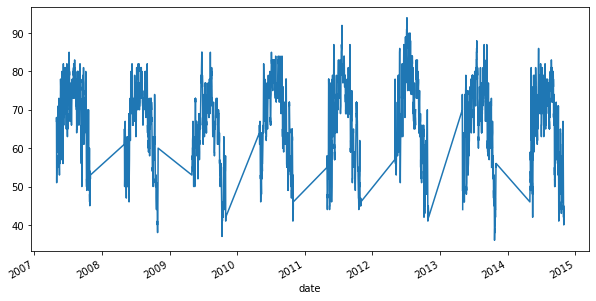

In [112]:
plt.figure(figsize=(10,5))
weather_to_plot.tavg.plot()

In [113]:
weather_to_plot['week'] = weather_to_plot.date.dt.week
weather_to_plot['month'] = weather_to_plot.date.dt.month
weather_to_plot['year'] = weather_to_plot.date.dt.year
weather_to_plot

<ipython-input-113-671bf3b3cc30>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  weather_to_plot['week'] = weather_to_plot.date.dt.week


,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,codesum,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,week,month,year
date,,,,,,,,,,,,,,,,,,,
2007-05-01,1,2007-05-01,83,50,67.0,51,56.0,0.0,2.0,Mod,0.00,29.10,29.82,1.7,27,9.2,18,5,2007
2007-05-01,2,2007-05-01,84,52,68.0,51,57.0,0.0,3.0,Mod,0.00,29.18,29.82,2.7,25,9.6,18,5,2007
2007-05-02,1,2007-05-02,59,42,51.0,42,47.0,14.0,0.0,BR,0.00,29.38,30.09,13.0,4,13.4,18,5,2007
2007-05-02,2,2007-05-02,60,43,52.0,42,47.0,13.0,0.0,BR HZ,0.00,29.44,30.08,13.3,2,13.4,18,5,2007
2007-05-03,1,2007-05-03,66,46,56.0,40,48.0,9.0,0.0,Mod,0.00,29.39,30.12,11.7,7,11.9,18,5,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-10-29,2,2014-10-29,49,40,45.0,34,42.0,20.0,0.0,Mod,0.00,29.42,30.07,8.5,29,9.0,44,10,2014
2014-10-30,1,2014-10-30,51,32,42.0,34,40.0,23.0,0.0,Mod,0.00,29.34,30.09,5.1,24,5.5,44,10,2014
2014-10-30,2,2014-10-30,53,37,45.0,35,42.0,20.0,0.0,RA,0.05,29.41,30.10,5.9,23,6.5,44,10,2014


In [114]:
weather_to_plot.columns

Index(['station', 'date', 'tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb',
       'heat', 'cool', 'codesum', 'preciptotal', 'stnpressure', 'sealevel',
       'resultspeed', 'resultdir', 'avgspeed', 'week', 'month', 'year'],
      dtype='object')

Text(0.5, 1.0, 'Average temperature and time')

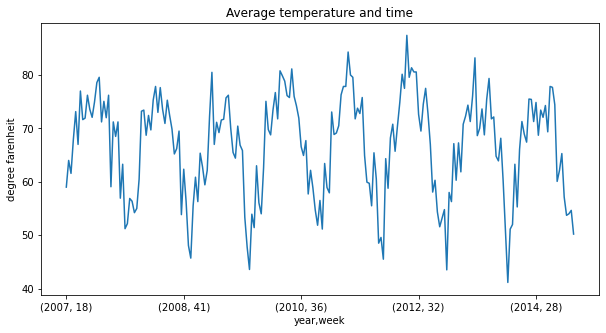

In [115]:
plt.figure(figsize=(10,5))
weather_to_plot.groupby(['year','week'])['tavg'].mean().plot()
plt.ylabel('degree farenheit')
plt.title('Average temperature and time')

There are seasonal pattern for average temperature.

In [116]:
train_weather['month'] = train_weather.index.month
train_weather['week'] = train_weather.index.week

<ipython-input-116-47d34e75efe0>:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  train_weather['week'] = train_weather.index.week


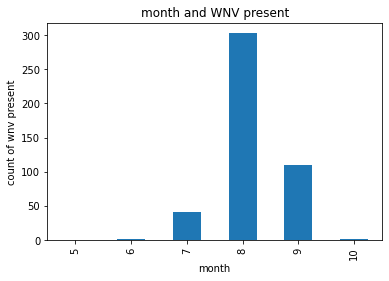

In [117]:
train_weather.groupby('month')['wnvpresent'].sum().plot(kind='bar')
plt.ylabel('count of wnv present')
plt.title('month and WNV present');

WNV present is peak in august.

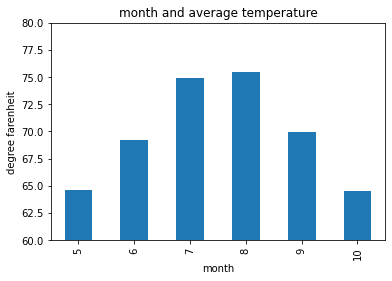

In [118]:
train_weather.groupby('month')['tavg'].mean().plot(kind='bar') 
plt.ylim(60,80)
plt.ylabel('degree farenheit')
plt.title('month and average temperature');

Avergae temperature also highest in Agust. 

<AxesSubplot:xlabel='year'>

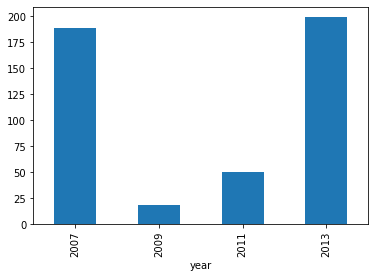

In [119]:
train_weather.groupby('year')['wnvpresent'].sum().plot(kind='bar')

# Data Preprocessing

## Dummy : Species

In [120]:
#drop columns that will be not use
#latlong - same with lat and long columns
#'station','addressaccuracy','trap' has no influence on virus
train_model = train_weather.drop(columns=['codesum','codesum-1','codesum-2','latlong','year','station','addressaccuracy','trap','week','month'])

In [121]:
train_model.shape

(8475, 44)

In [122]:
train.species.unique()

array(['CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

In [123]:
test.species.unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'UNSPECIFIED CULEX', 'CULEX ERRATICUS'], dtype=object)

In [124]:
#get dummies on species
train_model = pd.concat([train_model.drop(columns='species'),pd.get_dummies(train_model['species'],drop_first=False)],axis=1)

#drop_first = False since in test there is unspecified which can be baseline when we create model

In [125]:
train_model.columns

Index(['lat', 'long', 'nummosquitos', 'wnvpresent', 'tmax', 'tmin', 'tavg',
       'dewpoint', 'wetbulb', 'heat', 'cool', 'preciptotal', 'stnpressure',
       'sealevel', 'resultspeed', 'resultdir', 'avgspeed', 'tmax-1', 'tmin-1',
       'tavg-1', 'dewpoint-1', 'wetbulb-1', 'heat-1', 'cool-1',
       'preciptotal-1', 'stnpressure-1', 'sealevel-1', 'resultspeed-1',
       'resultdir-1', 'avgspeed-1', 'tmax-2', 'tmin-2', 'tavg-2', 'dewpoint-2',
       'wetbulb-2', 'heat-2', 'cool-2', 'preciptotal-2', 'stnpressure-2',
       'sealevel-2', 'resultspeed-2', 'resultdir-2', 'avgspeed-2',
       'CULEX ERRATICUS', 'CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS',
       'CULEX RESTUANS', 'CULEX SALINARIUS', 'CULEX TARSALIS',
       'CULEX TERRITANS'],
      dtype='object')

process the same for test

In [126]:
test_model = test_weather.drop(columns=['codesum','codesum-1','codesum-2','latlong','station','addressaccuracy','trap'])
test_model = pd.concat([test_model.drop(columns='species'),pd.get_dummies(test_model['species'])],axis=1)

## Dummy: Codesum

In [127]:
#extract only codesum 
codesum_df = train_weather[['codesum','codesum-1','codesum-2']]
codesum_df

,codesum,codesum-1,codesum-2
date,,,
2007-05-29,BR HZ,Mod,RA BR
2007-05-29,BR HZ,Mod,RA BR
2007-05-29,BR HZ,Mod,RA BR
2007-05-29,BR HZ,Mod,RA BR
2007-05-29,BR HZ,Mod,RA BR
...,...,...,...
2013-09-26,Mod,Mod,Mod
2013-09-26,Mod,Mod,Mod
2013-09-26,Mod,Mod,Mod


In [128]:
codesum_df.codesum.unique()

array(['BR HZ', 'RA BR', 'TSRA BR HZ VCTS', 'Mod', 'TSRA RA BR VCTS',
       'TS TSRA RA BR HZ VCTS', 'DZ BR', 'RA BR HZ', 'HZ', 'VCTS',
       'TSRA RA DZ BR HZ', 'TSRA RA', 'TSRA BR HZ', 'TSRA RA BR',
       'TS TSRA RA BR', 'BR', 'TSRA HZ', 'TSRA', 'RA', 'TS TSRA BR',
       'RA DZ BR', 'TS TSRA BR HZ', 'TS TSRA RA VCTS', 'TSRA BR', 'TS BR',
       'TS', 'FG BR HZ', 'TS TSRA RA FG BR HZ'], dtype=object)

To be sure that all the code is included, look for all code in all of columns.

In [129]:
a = [code.split() for code in codesum_df.codesum.unique()]
code = []
for i in range(len(a)):
    k = [x for x in a[i]]
    for j in range(len(k)):
        code.append(k[j])
code_1 = sorted(list(set(code)))
code_1

['BR', 'DZ', 'FG', 'HZ', 'Mod', 'RA', 'TS', 'TSRA', 'VCTS']

In [130]:
a = [code.split() for code in codesum_df['codesum-1'].unique()]
code = []
for i in range(len(a)):
    k = [x for x in a[i]]
    for j in range(len(k)):
        code.append(k[j])
code_2 = sorted(list(set(code)))
code_2

['BR', 'DZ', 'FG+', 'HZ', 'MIFG', 'Mod', 'RA', 'TS', 'TSRA', 'VCFG', 'VCTS']

In [131]:
a = [code.split() for code in codesum_df['codesum-2'].unique()]
code = []
for i in range(len(a)):
    k = [x for x in a[i]]
    for j in range(len(k)):
        code.append(k[j])
code_3 = sorted(list(set(code)))
code_3

['BR',
 'DZ',
 'FG',
 'FG+',
 'FU',
 'HZ',
 'MIFG',
 'Mod',
 'RA',
 'TS',
 'TSRA',
 'VCTS']

In [132]:
code = sorted(list(set(code_1+code_2+code_3)))
code.remove('Mod')
code #combine all the list and remove 'Mod' as the baseline

['BR',
 'DZ',
 'FG',
 'FG+',
 'FU',
 'HZ',
 'MIFG',
 'RA',
 'TS',
 'TSRA',
 'VCFG',
 'VCTS']

In [133]:
#Extract information from codesum columns to dummy columns we create
for j in [0,1,2]:
    if j==0:
        for i in range(len(code)):
            codesum_df['codesum_'+code[i]] = codesum_df['codesum'].str.contains(code[i]).astype(int)
    else:
        for i in range(len(code)):
            codesum_df['codesum_'+str(j)+'_'+code[i]] = codesum_df['codesum-'+str(j)].str.contains(code[i]).astype(int)

codesum_df

<ipython-input-133-d49f475319b3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codesum_df['codesum_'+code[i]] = codesum_df['codesum'].str.contains(code[i]).astype(int)
<ipython-input-133-d49f475319b3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codesum_df['codesum_'+str(j)+'_'+code[i]] = codesum_df['codesum-'+str(j)].str.contains(code[i]).astype(int)


,codesum,codesum-1,codesum-2,codesum_BR,codesum_DZ,codesum_FG,codesum_FG+,codesum_FU,codesum_HZ,codesum_MIFG,...,codesum_2_FG,codesum_2_FG+,codesum_2_FU,codesum_2_HZ,codesum_2_MIFG,codesum_2_RA,codesum_2_TS,codesum_2_TSRA,codesum_2_VCFG,codesum_2_VCTS
date,,,,,,,,,,,,,,,,,,,,,
2007-05-29,BR HZ,Mod,RA BR,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2007-05-29,BR HZ,Mod,RA BR,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2007-05-29,BR HZ,Mod,RA BR,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2007-05-29,BR HZ,Mod,RA BR,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2007-05-29,BR HZ,Mod,RA BR,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-09-26,Mod,Mod,Mod,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-09-26,Mod,Mod,Mod,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-09-26,Mod,Mod,Mod,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
codesum_df.columns

Index(['codesum', 'codesum-1', 'codesum-2', 'codesum_BR', 'codesum_DZ',
       'codesum_FG', 'codesum_FG+', 'codesum_FU', 'codesum_HZ', 'codesum_MIFG',
       'codesum_RA', 'codesum_TS', 'codesum_TSRA', 'codesum_VCFG',
       'codesum_VCTS', 'codesum_1_BR', 'codesum_1_DZ', 'codesum_1_FG',
       'codesum_1_FG+', 'codesum_1_FU', 'codesum_1_HZ', 'codesum_1_MIFG',
       'codesum_1_RA', 'codesum_1_TS', 'codesum_1_TSRA', 'codesum_1_VCFG',
       'codesum_1_VCTS', 'codesum_2_BR', 'codesum_2_DZ', 'codesum_2_FG',
       'codesum_2_FG+', 'codesum_2_FU', 'codesum_2_HZ', 'codesum_2_MIFG',
       'codesum_2_RA', 'codesum_2_TS', 'codesum_2_TSRA', 'codesum_2_VCFG',
       'codesum_2_VCTS'],
      dtype='object')

In [135]:
codesum_df = codesum_df.drop(columns=['codesum', 'codesum-1', 'codesum-2'])
train_model = pd.concat([train_model,codesum_df],axis=1)

In [136]:
codesum_df.shape

(8475, 36)

In [137]:
train_model.shape

(8475, 86)

In [138]:
#process for test
codesum_test_df = test_weather[['codesum','codesum-1','codesum-2']]
codesum_test_df

,codesum,codesum-1,codesum-2
0,Mod,RA,RA BR
1,Mod,RA,RA BR
2,Mod,RA,RA BR
3,Mod,RA,RA BR
4,Mod,RA,RA BR
...,...,...,...
116288,TSRA RA BR,RA,DZ BR
116289,TSRA RA BR,RA,DZ BR
116290,TSRA RA BR,RA,DZ BR
116291,TSRA RA BR,RA,DZ BR


In [139]:
for j in [0,1,2]:
    if j==0:
        for i in range(len(code)):
            codesum_test_df['codesum_'+code[i]] = codesum_test_df['codesum'].str.contains(code[i]).astype(int)
    else:
        for i in range(len(code)):
            codesum_test_df['codesum_'+str(j)+'_'+code[i]] = codesum_test_df['codesum-'+str(j)].str.contains(code[i]).astype(int)

codesum_test_df

<ipython-input-139-44275b1fabe9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codesum_test_df['codesum_'+code[i]] = codesum_test_df['codesum'].str.contains(code[i]).astype(int)
<ipython-input-139-44275b1fabe9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codesum_test_df['codesum_'+str(j)+'_'+code[i]] = codesum_test_df['codesum-'+str(j)].str.contains(code[i]).astype(int)


,codesum,codesum-1,codesum-2,codesum_BR,codesum_DZ,codesum_FG,codesum_FG+,codesum_FU,codesum_HZ,codesum_MIFG,...,codesum_2_FG,codesum_2_FG+,codesum_2_FU,codesum_2_HZ,codesum_2_MIFG,codesum_2_RA,codesum_2_TS,codesum_2_TSRA,codesum_2_VCFG,codesum_2_VCTS
0,Mod,RA,RA BR,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,Mod,RA,RA BR,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Mod,RA,RA BR,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,Mod,RA,RA BR,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,Mod,RA,RA BR,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116288,TSRA RA BR,RA,DZ BR,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116289,TSRA RA BR,RA,DZ BR,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116290,TSRA RA BR,RA,DZ BR,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116291,TSRA RA BR,RA,DZ BR,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [140]:
codesum_test_df = codesum_test_df.drop(columns=['codesum', 'codesum-1', 'codesum-2'])
test_model = pd.concat([test_model,codesum_test_df],axis=1)

In [141]:
train_model.shape

(8475, 86)

In [142]:
test_model.shape

(116293, 87)

## StandardScaler()

In [143]:
train_model.describe()

,lat,long,nummosquitos,wnvpresent,tmax,tmin,tavg,dewpoint,wetbulb,heat,...,codesum_2_FG,codesum_2_FG+,codesum_2_FU,codesum_2_HZ,codesum_2_MIFG,codesum_2_RA,codesum_2_TS,codesum_2_TSRA,codesum_2_VCFG,codesum_2_VCTS
count,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,...,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.0,8475.000000
mean,41.844618,-87.694788,15.933805,0.053923,81.357758,63.474808,72.648496,59.203776,64.409912,0.971445,...,0.028437,0.028437,0.016637,0.071976,0.005664,0.348319,0.199764,0.157286,0.0,0.039056
std,0.106609,0.084063,75.084707,0.225880,8.428245,7.719484,7.636167,7.994652,6.821400,2.808646,...,0.166226,0.166226,0.127915,0.258464,0.075049,0.476466,0.399846,0.364092,0.0,0.193740
min,41.644612,-87.930995,1.000000,0.000000,57.000000,41.000000,50.000000,38.000000,46.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,41.750498,-87.752329,2.000000,0.000000,78.000000,58.000000,70.000000,54.000000,60.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,41.857402,-87.694991,4.000000,0.000000,83.000000,65.000000,74.000000,59.000000,65.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,41.944869,-87.642984,11.000000,0.000000,87.000000,69.000000,78.000000,66.000000,70.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000
max,42.017430,-87.531635,2532.000000,1.000000,97.000000,79.000000,87.000000,73.000000,76.000000,15.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


In [144]:
train_model.columns

Index(['lat', 'long', 'nummosquitos', 'wnvpresent', 'tmax', 'tmin', 'tavg',
       'dewpoint', 'wetbulb', 'heat', 'cool', 'preciptotal', 'stnpressure',
       'sealevel', 'resultspeed', 'resultdir', 'avgspeed', 'tmax-1', 'tmin-1',
       'tavg-1', 'dewpoint-1', 'wetbulb-1', 'heat-1', 'cool-1',
       'preciptotal-1', 'stnpressure-1', 'sealevel-1', 'resultspeed-1',
       'resultdir-1', 'avgspeed-1', 'tmax-2', 'tmin-2', 'tavg-2', 'dewpoint-2',
       'wetbulb-2', 'heat-2', 'cool-2', 'preciptotal-2', 'stnpressure-2',
       'sealevel-2', 'resultspeed-2', 'resultdir-2', 'avgspeed-2',
       'CULEX ERRATICUS', 'CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS',
       'CULEX RESTUANS', 'CULEX SALINARIUS', 'CULEX TARSALIS',
       'CULEX TERRITANS', 'codesum_BR', 'codesum_DZ', 'codesum_FG',
       'codesum_FG+', 'codesum_FU', 'codesum_HZ', 'codesum_MIFG', 'codesum_RA',
       'codesum_TS', 'codesum_TSRA', 'codesum_VCFG', 'codesum_VCTS',
       'codesum_1_BR', 'codesum_1_DZ', 'codesum_1_FG', 'codesum

In [145]:
not_use = ['lat', 'long', 'nummosquitos', 'wnvpresent',
        'CULEX ERRATICUS','CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS',
       'CULEX SALINARIUS','CULEX TARSALIS', 'CULEX TERRITANS','codesum_BR',
       'codesum_DZ', 'codesum_FG', 'codesum_FG+', 'codesum_FU', 'codesum_HZ',
       'codesum_MIFG', 'codesum_RA', 'codesum_TS', 'codesum_TSRA',
       'codesum_VCFG', 'codesum_VCTS', 'codesum_1_BR', 'codesum_1_DZ',
       'codesum_1_FG', 'codesum_1_FG+', 'codesum_1_FU', 'codesum_1_HZ',
       'codesum_1_MIFG', 'codesum_1_RA', 'codesum_1_TS', 'codesum_1_TSRA',
       'codesum_1_VCFG', 'codesum_1_VCTS', 'codesum_2_BR', 'codesum_2_DZ',
       'codesum_2_FG', 'codesum_2_FG+', 'codesum_2_FU', 'codesum_2_HZ',
       'codesum_2_MIFG', 'codesum_2_RA', 'codesum_2_TS', 'codesum_2_TSRA',
       'codesum_2_VCFG', 'codesum_2_VCTS']

In [146]:
train_model.head()

,lat,long,nummosquitos,wnvpresent,tmax,tmin,tavg,dewpoint,wetbulb,heat,...,codesum_2_FG,codesum_2_FG+,codesum_2_FU,codesum_2_HZ,codesum_2_MIFG,codesum_2_RA,codesum_2_TS,codesum_2_TSRA,codesum_2_VCFG,codesum_2_VCTS
date,,,,,,,,,,,,,,,,,,,,,
2007-05-29,41.731922,-87.677512,1,0,88,65,77.0,59,66.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2007-05-29,41.867108,-87.654224,1,0,88,65,77.0,59,66.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2007-05-29,41.919343,-87.694259,1,0,88,65,77.0,59,66.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2007-05-29,41.921965,-87.632085,2,0,88,65,77.0,59,66.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2007-05-29,41.688324,-87.676709,1,0,88,65,77.0,59,66.0,0.0,...,0,0,0,0,0,1,0,0,0,0


In [147]:
train_to_ss = train_model[[col for col in train_model.columns if col not in not_use]]
train_to_ss.head()

,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,...,dewpoint-2,wetbulb-2,heat-2,cool-2,preciptotal-2,stnpressure-2,sealevel-2,resultspeed-2,resultdir-2,avgspeed-2
date,,,,,,,,,,,,,,,,,,,,,
2007-05-29,88,65,77.0,59,66.0,0.0,12.0,0.0,29.44,30.09,...,49.0,57.0,0.0,2.0,0.08,29.41,30.05,8.2,24.0,9.2
2007-05-29,88,65,77.0,59,66.0,0.0,12.0,0.0,29.44,30.09,...,49.0,57.0,0.0,2.0,0.08,29.41,30.05,8.2,24.0,9.2
2007-05-29,88,65,77.0,59,66.0,0.0,12.0,0.0,29.44,30.09,...,49.0,57.0,0.0,2.0,0.08,29.41,30.05,8.2,24.0,9.2
2007-05-29,88,65,77.0,59,66.0,0.0,12.0,0.0,29.44,30.09,...,49.0,57.0,0.0,2.0,0.08,29.41,30.05,8.2,24.0,9.2
2007-05-29,88,65,77.0,59,66.0,0.0,12.0,0.0,29.44,30.09,...,49.0,57.0,0.0,2.0,0.08,29.41,30.05,8.2,24.0,9.2


In [148]:
ss = StandardScaler()
train_ss = ss.fit_transform(train_to_ss)
train_ss = pd.DataFrame(train_ss,columns = train_to_ss.columns)
train_ss

,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,...,dewpoint-2,wetbulb-2,heat-2,cool-2,preciptotal-2,stnpressure-2,sealevel-2,resultspeed-2,resultdir-2,avgspeed-2
0,0.788140,0.197589,0.569888,-0.025491,0.233117,-0.345897,0.582518,-0.413861,1.22047,1.084001,...,-1.262318,-1.098949,-0.310089,-0.933342,-0.184208,0.822824,0.611049,0.741869,0.882715,0.533674
1,0.788140,0.197589,0.569888,-0.025491,0.233117,-0.345897,0.582518,-0.413861,1.22047,1.084001,...,-1.262318,-1.098949,-0.310089,-0.933342,-0.184208,0.822824,0.611049,0.741869,0.882715,0.533674
2,0.788140,0.197589,0.569888,-0.025491,0.233117,-0.345897,0.582518,-0.413861,1.22047,1.084001,...,-1.262318,-1.098949,-0.310089,-0.933342,-0.184208,0.822824,0.611049,0.741869,0.882715,0.533674
3,0.788140,0.197589,0.569888,-0.025491,0.233117,-0.345897,0.582518,-0.413861,1.22047,1.084001,...,-1.262318,-1.098949,-0.310089,-0.933342,-0.184208,0.822824,0.611049,0.741869,0.882715,0.533674
4,0.788140,0.197589,0.569888,-0.025491,0.233117,-0.345897,0.582518,-0.413861,1.22047,1.084001,...,-1.262318,-1.098949,-0.310089,-0.933342,-0.184208,0.822824,0.611049,0.741869,0.882715,0.533674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8470,-0.754384,-1.097911,-1.001674,-0.901128,-0.939732,-0.345897,-1.485556,-0.413861,0.88820,0.669639,...,-1.394410,-1.578249,0.143485,-1.259101,-0.325910,0.226415,0.246674,-0.117067,-0.684907,-0.078409
8471,-0.754384,-1.097911,-1.001674,-0.901128,-0.939732,-0.345897,-1.485556,-0.413861,0.88820,0.669639,...,-1.394410,-1.578249,0.143485,-1.259101,-0.325910,0.226415,0.246674,-0.117067,-0.684907,-0.078409
8472,-0.754384,-1.097911,-1.001674,-0.901128,-0.939732,-0.345897,-1.485556,-0.413861,0.88820,0.669639,...,-1.394410,-1.578249,0.143485,-1.259101,-0.325910,0.226415,0.246674,-0.117067,-0.684907,-0.078409
8473,-0.754384,-1.097911,-1.001674,-0.901128,-0.939732,-0.345897,-1.485556,-0.413861,0.88820,0.669639,...,-1.394410,-1.578249,0.143485,-1.259101,-0.325910,0.226415,0.246674,-0.117067,-0.684907,-0.078409


In [149]:
train_model = train_model.reset_index(drop=True)
train_not_ss = train_model[not_use]

In [150]:
train_not_ss.columns

Index(['lat', 'long', 'nummosquitos', 'wnvpresent', 'CULEX ERRATICUS',
       'CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS',
       'CULEX SALINARIUS', 'CULEX TARSALIS', 'CULEX TERRITANS', 'codesum_BR',
       'codesum_DZ', 'codesum_FG', 'codesum_FG+', 'codesum_FU', 'codesum_HZ',
       'codesum_MIFG', 'codesum_RA', 'codesum_TS', 'codesum_TSRA',
       'codesum_VCFG', 'codesum_VCTS', 'codesum_1_BR', 'codesum_1_DZ',
       'codesum_1_FG', 'codesum_1_FG+', 'codesum_1_FU', 'codesum_1_HZ',
       'codesum_1_MIFG', 'codesum_1_RA', 'codesum_1_TS', 'codesum_1_TSRA',
       'codesum_1_VCFG', 'codesum_1_VCTS', 'codesum_2_BR', 'codesum_2_DZ',
       'codesum_2_FG', 'codesum_2_FG+', 'codesum_2_FU', 'codesum_2_HZ',
       'codesum_2_MIFG', 'codesum_2_RA', 'codesum_2_TS', 'codesum_2_TSRA',
       'codesum_2_VCFG', 'codesum_2_VCTS'],
      dtype='object')

In [151]:
train_final = pd.concat([train_ss,train_not_ss],axis=1)
train_final

,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,...,codesum_2_FG,codesum_2_FG+,codesum_2_FU,codesum_2_HZ,codesum_2_MIFG,codesum_2_RA,codesum_2_TS,codesum_2_TSRA,codesum_2_VCFG,codesum_2_VCTS
0,0.788140,0.197589,0.569888,-0.025491,0.233117,-0.345897,0.582518,-0.413861,1.22047,1.084001,...,0,0,0,0,0,1,0,0,0,0
1,0.788140,0.197589,0.569888,-0.025491,0.233117,-0.345897,0.582518,-0.413861,1.22047,1.084001,...,0,0,0,0,0,1,0,0,0,0
2,0.788140,0.197589,0.569888,-0.025491,0.233117,-0.345897,0.582518,-0.413861,1.22047,1.084001,...,0,0,0,0,0,1,0,0,0,0
3,0.788140,0.197589,0.569888,-0.025491,0.233117,-0.345897,0.582518,-0.413861,1.22047,1.084001,...,0,0,0,0,0,1,0,0,0,0
4,0.788140,0.197589,0.569888,-0.025491,0.233117,-0.345897,0.582518,-0.413861,1.22047,1.084001,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8470,-0.754384,-1.097911,-1.001674,-0.901128,-0.939732,-0.345897,-1.485556,-0.413861,0.88820,0.669639,...,0,0,0,0,0,0,0,0,0,0
8471,-0.754384,-1.097911,-1.001674,-0.901128,-0.939732,-0.345897,-1.485556,-0.413861,0.88820,0.669639,...,0,0,0,0,0,0,0,0,0,0
8472,-0.754384,-1.097911,-1.001674,-0.901128,-0.939732,-0.345897,-1.485556,-0.413861,0.88820,0.669639,...,0,0,0,0,0,0,0,0,0,0
8473,-0.754384,-1.097911,-1.001674,-0.901128,-0.939732,-0.345897,-1.485556,-0.413861,0.88820,0.669639,...,0,0,0,0,0,0,0,0,0,0


In [152]:
train_final.columns

Index(['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed', 'tmax-1', 'tmin-1', 'tavg-1', 'dewpoint-1', 'wetbulb-1',
       'heat-1', 'cool-1', 'preciptotal-1', 'stnpressure-1', 'sealevel-1',
       'resultspeed-1', 'resultdir-1', 'avgspeed-1', 'tmax-2', 'tmin-2',
       'tavg-2', 'dewpoint-2', 'wetbulb-2', 'heat-2', 'cool-2',
       'preciptotal-2', 'stnpressure-2', 'sealevel-2', 'resultspeed-2',
       'resultdir-2', 'avgspeed-2', 'lat', 'long', 'nummosquitos',
       'wnvpresent', 'CULEX ERRATICUS', 'CULEX PIPIENS',
       'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX SALINARIUS',
       'CULEX TARSALIS', 'CULEX TERRITANS', 'codesum_BR', 'codesum_DZ',
       'codesum_FG', 'codesum_FG+', 'codesum_FU', 'codesum_HZ', 'codesum_MIFG',
       'codesum_RA', 'codesum_TS', 'codesum_TSRA', 'codesum_VCFG',
       'codesum_VCTS', 'codesum_1_BR', 'codesum_1_DZ', 'codesum_1_FG',
       '

## Preprocess test_model

In [153]:
test_model.columns

Index(['id', 'date', 'lat', 'long', 'tmax', 'tmin', 'tavg', 'dewpoint',
       'wetbulb', 'heat', 'cool', 'preciptotal', 'stnpressure', 'sealevel',
       'resultspeed', 'resultdir', 'avgspeed', 'tmax-1', 'tmin-1', 'tavg-1',
       'dewpoint-1', 'wetbulb-1', 'heat-1', 'cool-1', 'preciptotal-1',
       'stnpressure-1', 'sealevel-1', 'resultspeed-1', 'resultdir-1',
       'avgspeed-1', 'tmax-2', 'tmin-2', 'tavg-2', 'dewpoint-2', 'wetbulb-2',
       'heat-2', 'cool-2', 'preciptotal-2', 'stnpressure-2', 'sealevel-2',
       'resultspeed-2', 'resultdir-2', 'avgspeed-2', 'CULEX ERRATICUS',
       'CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS',
       'CULEX SALINARIUS', 'CULEX TARSALIS', 'CULEX TERRITANS',
       'UNSPECIFIED CULEX', 'codesum_BR', 'codesum_DZ', 'codesum_FG',
       'codesum_FG+', 'codesum_FU', 'codesum_HZ', 'codesum_MIFG', 'codesum_RA',
       'codesum_TS', 'codesum_TSRA', 'codesum_VCFG', 'codesum_VCTS',
       'codesum_1_BR', 'codesum_1_DZ', 'codesum_1_FG', 'co

In [154]:
not_use_test = ['id','date','lat', 'long','CULEX ERRATICUS','CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS',
       'CULEX SALINARIUS', 'CULEX TARSALIS', 'CULEX TERRITANS','UNSPECIFIED CULEX','codesum_BR',
       'codesum_DZ', 'codesum_FG', 'codesum_FG+', 'codesum_FU', 'codesum_HZ',
       'codesum_MIFG', 'codesum_RA', 'codesum_TS', 'codesum_TSRA',
       'codesum_VCFG', 'codesum_VCTS', 'codesum_1_BR', 'codesum_1_DZ',
       'codesum_1_FG', 'codesum_1_FG+', 'codesum_1_FU', 'codesum_1_HZ',
       'codesum_1_MIFG', 'codesum_1_RA', 'codesum_1_TS', 'codesum_1_TSRA',
       'codesum_1_VCFG', 'codesum_1_VCTS', 'codesum_2_BR', 'codesum_2_DZ',
       'codesum_2_FG', 'codesum_2_FG+', 'codesum_2_FU', 'codesum_2_HZ',
       'codesum_2_MIFG', 'codesum_2_RA', 'codesum_2_TS', 'codesum_2_TSRA',
       'codesum_2_VCFG', 'codesum_2_VCTS']

In [155]:
test_to_ss = test_model[[col for col in test_model.columns if col not in not_use_test]]
test_to_ss.head()

,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,...,dewpoint-2,wetbulb-2,heat-2,cool-2,preciptotal-2,stnpressure-2,sealevel-2,resultspeed-2,resultdir-2,avgspeed-2
0,86,61,74.0,56,64.0,0.0,9.0,0.0,29.28,29.99,...,64.0,66.0,0.0,5.0,0.14,29.1,29.82,6.3,22.0,7.7
1,86,61,74.0,56,64.0,0.0,9.0,0.0,29.28,29.99,...,64.0,66.0,0.0,5.0,0.14,29.1,29.82,6.3,22.0,7.7
2,86,61,74.0,56,64.0,0.0,9.0,0.0,29.28,29.99,...,64.0,66.0,0.0,5.0,0.14,29.1,29.82,6.3,22.0,7.7
3,86,61,74.0,56,64.0,0.0,9.0,0.0,29.28,29.99,...,64.0,66.0,0.0,5.0,0.14,29.1,29.82,6.3,22.0,7.7
4,86,61,74.0,56,64.0,0.0,9.0,0.0,29.28,29.99,...,64.0,66.0,0.0,5.0,0.14,29.1,29.82,6.3,22.0,7.7


In [156]:
test_ss = ss.transform(test_to_ss)
test_ss = pd.DataFrame(test_ss,columns = test_to_ss.columns)
test_ss.head()

,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,...,dewpoint-2,wetbulb-2,heat-2,cool-2,preciptotal-2,stnpressure-2,sealevel-2,resultspeed-2,resultdir-2,avgspeed-2
0,0.550828,-0.320611,0.176998,-0.400764,-0.060096,-0.345897,0.065499,-0.413861,-0.10861,0.255276,...,0.719064,0.33895,-0.310089,-0.444704,-0.077932,-1.48826,-1.065075,0.061878,0.673698,-0.078409
1,0.550828,-0.320611,0.176998,-0.400764,-0.060096,-0.345897,0.065499,-0.413861,-0.10861,0.255276,...,0.719064,0.33895,-0.310089,-0.444704,-0.077932,-1.48826,-1.065075,0.061878,0.673698,-0.078409
2,0.550828,-0.320611,0.176998,-0.400764,-0.060096,-0.345897,0.065499,-0.413861,-0.10861,0.255276,...,0.719064,0.33895,-0.310089,-0.444704,-0.077932,-1.48826,-1.065075,0.061878,0.673698,-0.078409
3,0.550828,-0.320611,0.176998,-0.400764,-0.060096,-0.345897,0.065499,-0.413861,-0.10861,0.255276,...,0.719064,0.33895,-0.310089,-0.444704,-0.077932,-1.48826,-1.065075,0.061878,0.673698,-0.078409
4,0.550828,-0.320611,0.176998,-0.400764,-0.060096,-0.345897,0.065499,-0.413861,-0.10861,0.255276,...,0.719064,0.33895,-0.310089,-0.444704,-0.077932,-1.48826,-1.065075,0.061878,0.673698,-0.078409


In [157]:
test_model = test_model.reset_index(drop=True)
test_not_ss = test_model[not_use_test]
test_not_ss.head()

,id,date,lat,long,CULEX ERRATICUS,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX SALINARIUS,CULEX TARSALIS,...,codesum_2_FG,codesum_2_FG+,codesum_2_FU,codesum_2_HZ,codesum_2_MIFG,codesum_2_RA,codesum_2_TS,codesum_2_TSRA,codesum_2_VCFG,codesum_2_VCTS
0,1,2008-06-11,41.95469,-87.800991,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,2008-06-11,41.95469,-87.800991,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,3,2008-06-11,41.95469,-87.800991,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,2008-06-11,41.95469,-87.800991,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,2008-06-11,41.95469,-87.800991,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [158]:
test_final = pd.concat([test_ss,test_not_ss],axis=1)
test_final

,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,...,codesum_2_FG,codesum_2_FG+,codesum_2_FU,codesum_2_HZ,codesum_2_MIFG,codesum_2_RA,codesum_2_TS,codesum_2_TSRA,codesum_2_VCFG,codesum_2_VCTS
0,0.550828,-0.320611,0.176998,-0.400764,-0.060096,-0.345897,0.065499,-0.413861,-0.108610,0.255276,...,0,0,0,0,0,1,0,0,0,0
1,0.550828,-0.320611,0.176998,-0.400764,-0.060096,-0.345897,0.065499,-0.413861,-0.108610,0.255276,...,0,0,0,0,0,1,0,0,0,0
2,0.550828,-0.320611,0.176998,-0.400764,-0.060096,-0.345897,0.065499,-0.413861,-0.108610,0.255276,...,0,0,0,0,0,1,0,0,0,0
3,0.550828,-0.320611,0.176998,-0.400764,-0.060096,-0.345897,0.065499,-0.413861,-0.108610,0.255276,...,0,0,0,0,0,1,0,0,0,0
4,0.550828,-0.320611,0.176998,-0.400764,-0.060096,-0.345897,0.065499,-0.413861,-0.108610,0.255276,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116288,-0.754384,0.327139,-0.215893,0.474874,0.086511,-0.345897,-0.451519,1.620161,-1.603826,-1.485045,...,0,0,0,0,0,0,0,0,0,0
116289,-0.754384,0.327139,-0.215893,0.474874,0.086511,-0.345897,-0.451519,1.620161,-1.603826,-1.485045,...,0,0,0,0,0,0,0,0,0,0
116290,-0.754384,0.327139,-0.215893,0.474874,0.086511,-0.345897,-0.451519,1.620161,-1.603826,-1.485045,...,0,0,0,0,0,0,0,0,0,0
116291,-0.754384,0.327139,-0.215893,0.474874,0.086511,-0.345897,-0.451519,1.620161,-1.603826,-1.485045,...,0,0,0,0,0,0,0,0,0,0


# Data Modeling

## Baseline Model

In [159]:
train_final.columns

Index(['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed', 'tmax-1', 'tmin-1', 'tavg-1', 'dewpoint-1', 'wetbulb-1',
       'heat-1', 'cool-1', 'preciptotal-1', 'stnpressure-1', 'sealevel-1',
       'resultspeed-1', 'resultdir-1', 'avgspeed-1', 'tmax-2', 'tmin-2',
       'tavg-2', 'dewpoint-2', 'wetbulb-2', 'heat-2', 'cool-2',
       'preciptotal-2', 'stnpressure-2', 'sealevel-2', 'resultspeed-2',
       'resultdir-2', 'avgspeed-2', 'lat', 'long', 'nummosquitos',
       'wnvpresent', 'CULEX ERRATICUS', 'CULEX PIPIENS',
       'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX SALINARIUS',
       'CULEX TARSALIS', 'CULEX TERRITANS', 'codesum_BR', 'codesum_DZ',
       'codesum_FG', 'codesum_FG+', 'codesum_FU', 'codesum_HZ', 'codesum_MIFG',
       'codesum_RA', 'codesum_TS', 'codesum_TSRA', 'codesum_VCFG',
       'codesum_VCTS', 'codesum_1_BR', 'codesum_1_DZ', 'codesum_1_FG',
       '

In [160]:
#define X,y
X = train_final.drop(columns=['wnvpresent','nummosquitos'])
y = train_final['wnvpresent']

In [161]:
X.columns

Index(['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed', 'tmax-1', 'tmin-1', 'tavg-1', 'dewpoint-1', 'wetbulb-1',
       'heat-1', 'cool-1', 'preciptotal-1', 'stnpressure-1', 'sealevel-1',
       'resultspeed-1', 'resultdir-1', 'avgspeed-1', 'tmax-2', 'tmin-2',
       'tavg-2', 'dewpoint-2', 'wetbulb-2', 'heat-2', 'cool-2',
       'preciptotal-2', 'stnpressure-2', 'sealevel-2', 'resultspeed-2',
       'resultdir-2', 'avgspeed-2', 'lat', 'long', 'CULEX ERRATICUS',
       'CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS',
       'CULEX SALINARIUS', 'CULEX TARSALIS', 'CULEX TERRITANS', 'codesum_BR',
       'codesum_DZ', 'codesum_FG', 'codesum_FG+', 'codesum_FU', 'codesum_HZ',
       'codesum_MIFG', 'codesum_RA', 'codesum_TS', 'codesum_TSRA',
       'codesum_VCFG', 'codesum_VCTS', 'codesum_1_BR', 'codesum_1_DZ',
       'codesum_1_FG', 'codesum_1_FG+', 'codesum_1_FU', 'code

In [162]:
y.value_counts(normalize=True) 

0    0.946077
1    0.053923
Name: wnvpresent, dtype: float64

In [163]:
X_train,X_val,y_train,y_val = train_test_split(X,y,random_state=42,stratify=y)
y_train.value_counts()

0    6013
1     343
Name: wnvpresent, dtype: int64

In [164]:
#define classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)
print(f"""
accuracy: {rf.score(X_train,y_train)}
roc_auc: {roc_auc_score(y_train,rf.predict_proba(X_train)[:,1]) }""") 


accuracy: 1.0
roc_auc: 1.0


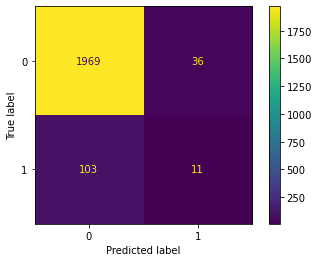

In [165]:
plot_confusion_matrix(rf,X_val,y_val)

In [166]:
print(f"""Validation Score:
accuracy: {rf.score(X_val,y_val)}
roc_auc: {roc_auc_score(y_val,rf.predict_proba(X_val)[:,1]) }""") 

Validation Score:
accuracy: 0.9344030202925908
roc_auc: 0.7830817692610579


## Try prediction with the baseline model

In [167]:
X_test = test_final.drop(columns=['date','id','UNSPECIFIED CULEX'])
X_test

,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,...,codesum_2_FG,codesum_2_FG+,codesum_2_FU,codesum_2_HZ,codesum_2_MIFG,codesum_2_RA,codesum_2_TS,codesum_2_TSRA,codesum_2_VCFG,codesum_2_VCTS
0,0.550828,-0.320611,0.176998,-0.400764,-0.060096,-0.345897,0.065499,-0.413861,-0.108610,0.255276,...,0,0,0,0,0,1,0,0,0,0
1,0.550828,-0.320611,0.176998,-0.400764,-0.060096,-0.345897,0.065499,-0.413861,-0.108610,0.255276,...,0,0,0,0,0,1,0,0,0,0
2,0.550828,-0.320611,0.176998,-0.400764,-0.060096,-0.345897,0.065499,-0.413861,-0.108610,0.255276,...,0,0,0,0,0,1,0,0,0,0
3,0.550828,-0.320611,0.176998,-0.400764,-0.060096,-0.345897,0.065499,-0.413861,-0.108610,0.255276,...,0,0,0,0,0,1,0,0,0,0
4,0.550828,-0.320611,0.176998,-0.400764,-0.060096,-0.345897,0.065499,-0.413861,-0.108610,0.255276,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116288,-0.754384,0.327139,-0.215893,0.474874,0.086511,-0.345897,-0.451519,1.620161,-1.603826,-1.485045,...,0,0,0,0,0,0,0,0,0,0
116289,-0.754384,0.327139,-0.215893,0.474874,0.086511,-0.345897,-0.451519,1.620161,-1.603826,-1.485045,...,0,0,0,0,0,0,0,0,0,0
116290,-0.754384,0.327139,-0.215893,0.474874,0.086511,-0.345897,-0.451519,1.620161,-1.603826,-1.485045,...,0,0,0,0,0,0,0,0,0,0
116291,-0.754384,0.327139,-0.215893,0.474874,0.086511,-0.345897,-0.451519,1.620161,-1.603826,-1.485045,...,0,0,0,0,0,0,0,0,0,0


In [168]:
#predict
ypred = rf.predict(X_test)
pd.Series(ypred).value_counts()

0    116293
dtype: int64

Baseline model did not predict any positive class. So this will not be used to submit into kaggle

### Model0: Use SMOTE

In [169]:
sm = SMOTE(random_state=42)
Xsm,ysm = sm.fit_resample(X_train,y_train)
pd.Series(ysm).value_counts()

1    6013
0    6013
Name: wnvpresent, dtype: int64

In [170]:
rf2 = RandomForestClassifier()
rf2.fit(Xsm,ysm)
print(f"""Validiting ROC_AUC Score: {roc_auc_score(y_val,rf2.predict(X_val)) }""") 

Validiting ROC_AUC Score: 0.6212363827273921


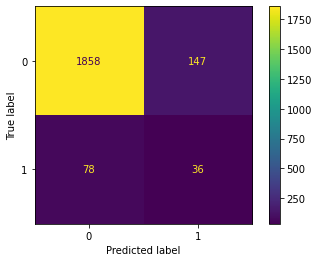

In [171]:
plot_confusion_matrix(rf2,X_val,y_val)

In [172]:
#predict with rf2
ypred = rf2.predict(X_test)
pd.Series(ypred).value_counts()

0    94463
1    21830
dtype: int64

In [173]:
#get predict_prob used for sbumit
ypred_prob = rf2.predict_proba(X_test)
ypred_prob

array([[0.54, 0.46],
       [0.78, 0.22],
       [0.58, 0.42],
       ...,
       [0.73, 0.27],
       [0.73, 0.27],
       [0.73, 0.27]])

In [174]:
test.shape

(116293, 9)

In [175]:
#create submit
submit = pd.DataFrame()
submit['Id'] = test_final.id
submit['WnvPresent'] = [x[1] for x in ypred_prob]
submit.head()

,Id,WnvPresent
0,1,0.46
1,2,0.22
2,3,0.42
3,4,0.43
4,5,0.43


In [176]:
submit.to_csv('baseline.csv',index=False)

**Private Score: 0.58293**

# Finding Best Regression Model: Predict nummosquitos

In [177]:
#define variable to build dataframe
model = []
r2_score_list = []
r2_cv_score_list = []
rmse_score_list = []

In [178]:
train_final.columns

Index(['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed', 'tmax-1', 'tmin-1', 'tavg-1', 'dewpoint-1', 'wetbulb-1',
       'heat-1', 'cool-1', 'preciptotal-1', 'stnpressure-1', 'sealevel-1',
       'resultspeed-1', 'resultdir-1', 'avgspeed-1', 'tmax-2', 'tmin-2',
       'tavg-2', 'dewpoint-2', 'wetbulb-2', 'heat-2', 'cool-2',
       'preciptotal-2', 'stnpressure-2', 'sealevel-2', 'resultspeed-2',
       'resultdir-2', 'avgspeed-2', 'lat', 'long', 'nummosquitos',
       'wnvpresent', 'CULEX ERRATICUS', 'CULEX PIPIENS',
       'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX SALINARIUS',
       'CULEX TARSALIS', 'CULEX TERRITANS', 'codesum_BR', 'codesum_DZ',
       'codesum_FG', 'codesum_FG+', 'codesum_FU', 'codesum_HZ', 'codesum_MIFG',
       'codesum_RA', 'codesum_TS', 'codesum_TSRA', 'codesum_VCFG',
       'codesum_VCTS', 'codesum_1_BR', 'codesum_1_DZ', 'codesum_1_FG',
       '

Using all the features with the model with default hyperparameters.

In [179]:
X = train_final.drop(columns=['wnvpresent','nummosquitos'])
y = train_final['nummosquitos']

In [180]:
X.shape

(8475, 84)

In [181]:
X.shape

(8475, 84)

In [182]:
lr = LinearRegression()
lr.fit(X,y)
print('LR R2 Score:', lr.score(X,y))
print('LR R2 CV Score:',cross_val_score(lr,X,y,cv=5).mean())
print('LR RMSE Score:', np.abs(cross_val_score(lr,X,y,cv=5,scoring='neg_root_mean_squared_error').mean()))

model.append('LinearRegression')
r2_score_list.append(lr.score(X,y))
r2_cv_score_list.append(cross_val_score(lr,X,y,cv=5).mean())
rmse_score_list.append(np.abs(cross_val_score(lr,X,y,cv=5,scoring='neg_root_mean_squared_error').mean()))

LR R2 Score: 0.04595395795421975
LR R2 CV Score: -5.384969883354735e+23
LR RMSE Score: 9507764116449.25


In [183]:
ridgeCV = RidgeCV(alphas = np.linspace(0.1,10,50))
ridgeCV.fit(X,y)
ridge = Ridge(alpha=(ridgeCV.alpha_))
ridge.fit(X,y)

Ridge(alpha=9.191836734693878)

In [184]:
ridge_r2_score = ridge.score(X,y)
print("Ridge R2 Score:",ridge_r2_score)
ridge_r2_cv_x_train_sc = cross_val_score(ridge,X,y, cv=5)
print("Ridge R2 CV Score:",ridge_r2_cv_x_train_sc.mean())
ridge_rmse_cv_x_train_sc = cross_val_score(ridge,X,y,cv=5,scoring='neg_root_mean_squared_error')
print("Ridge RMSE CV:",np.abs(ridge_rmse_cv_x_train_sc.mean()))

model.append('Ridge')
r2_score_list.append(ridge_r2_score)
r2_cv_score_list.append(ridge_r2_cv_x_train_sc.mean())
rmse_score_list.append(np.abs(ridge_rmse_cv_x_train_sc.mean()))

Ridge R2 Score: 0.04463398618897507
Ridge R2 CV Score: -1.7536553200369493
Ridge RMSE CV: 79.0996765758329


In [185]:
lassoCV = LassoCV(n_alphas=3000)
lassoCV.fit(X,y)
lasso = Lasso(alpha=(lassoCV.alpha_))
lasso.fit(X,y)

C:\Users\Dip\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4738.596555352211, tolerance: 4612.089175162251
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Dip\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4635.053643681109, tolerance: 4612.089175162251
  model = cd_fast.enet_coordinate_descent_gram(


Lasso(alpha=2.253679533274879)

In [186]:
lasso_r2_score = lasso.score(X,y)
print("Lasso R2 Score:",lasso_r2_score)
lasso_r2_cv_x_train_sc = cross_val_score(lasso, X,y, cv=5)
print("Lasso R2 CV Score:",lasso_r2_cv_x_train_sc.mean())
lasso_rmse_cv_x_train_sc = cross_val_score(lasso,X,y,cv=5,scoring='neg_root_mean_squared_error')
print("Lasso RMSE CV:",np.abs(lasso_rmse_cv_x_train_sc.mean()))

model.append('Lasso')
r2_score_list.append(lasso_r2_score)
r2_cv_score_list.append(lasso_r2_cv_x_train_sc.mean())
rmse_score_list.append(np.abs(lasso_rmse_cv_x_train_sc.mean()))

Lasso R2 Score: 0.004327230741178911
Lasso R2 CV Score: -0.03145391468654699
Lasso RMSE CV: 63.687660009983446


In [187]:
elcv = ElasticNetCV(n_alphas=100, l1_ratio=[.1,.2,.3,.4,.5,.6,.7,.8,.9],max_iter=10**6)
elcv.fit(X,y)
el = ElasticNet(alpha=(elcv.alpha_), l1_ratio=(elcv.l1_ratio_),max_iter=10**6)
el.fit(X,y)

ElasticNet(alpha=7.617738280980179, l1_ratio=0.1, max_iter=1000000)

In [188]:
el_r2_score = el.score(X,y)
print("EL R2 Score:",el_r2_score)
el_r2_cv_x_train_sc = cross_val_score(el, X,y, cv=5)
print("EL R2 CV Score:",el_r2_cv_x_train_sc.mean())
el_rmse_cv_x_train_sc = cross_val_score(el,X,y,cv=5,scoring='neg_root_mean_squared_error')
print("EL RMSE CV:",np.abs(el_rmse_cv_x_train_sc.mean()))

model.append('ElasticNet')
r2_score_list.append(el_r2_score)
r2_cv_score_list.append(el_r2_cv_x_train_sc.mean())
rmse_score_list.append(np.abs(el_rmse_cv_x_train_sc.mean()))

EL R2 Score: 0.004271054813678177
EL R2 CV Score: -0.0256230572830884
EL RMSE CV: 63.59662782772051


In [189]:
knr = KNeighborsRegressor()
knr.fit(X,y)
r2_score = knr.score(X,y)
r2_cv_score = cross_val_score(knr,X,y,cv=5).mean()
rmse_score = np.abs(cross_val_score(knr,X,y,cv=5,scoring='neg_root_mean_squared_error').mean())
print('KNR R2 Score:', r2_score)
print('KNR R2 CV Score:',r2_cv_score)
print('KNR RMSE Score:', rmse_score)

model.append('KNeighborsRegressor')
r2_score_list.append(r2_score)
r2_cv_score_list.append(r2_cv_score)
rmse_score_list.append(rmse_score)

KNR R2 Score: 0.37493666899020817
KNR R2 CV Score: -11.34680937097728
KNR RMSE Score: 123.50225489516376


In [190]:
abr = AdaBoostRegressor()
abr.fit(X, y)
r2_score = abr.score(X,y)
r2_cv_score = cross_val_score(abr,X,y,cv=5).mean()
rmse_score = np.abs(cross_val_score(abr,X,y,cv=5,scoring='neg_root_mean_squared_error').mean())
print('ABR R2 Score:', r2_score)
print('ABR R2 CV Score:',r2_cv_score)
print('ABR RMSE Score:', rmse_score)

model.append('AdaBoostRegressor')
r2_score_list.append(r2_score)
r2_cv_score_list.append(r2_cv_score)
rmse_score_list.append(rmse_score)

ABR R2 Score: 0.5007076863898496
ABR R2 CV Score: -5.032449247841742
ABR RMSE Score: 90.35566007342867


In [191]:
gbr = GradientBoostingRegressor()
gbr.fit(X, y)
r2_score = gbr.score(X,y)
r2_cv_score = cross_val_score(gbr,X,y,cv=5).mean()
rmse_score = np.abs(cross_val_score(gbr,X,y,cv=5,scoring='neg_root_mean_squared_error').mean())
print('GBR R2 Score:', r2_score)
print('GBR R2 CV Score:',r2_cv_score)
print('GBR RMSE Score:',rmse_score)

model.append('GradientBoostingRegressor')
r2_score_list.append(r2_score)
r2_cv_score_list.append(r2_cv_score)
rmse_score_list.append(rmse_score)

GBR R2 Score: 0.49103452038868056
GBR R2 CV Score: -2.7881726342210618
GBR RMSE Score: 98.5439848669939


In [192]:
bgr = BaggingRegressor()
bgr.fit(X,y)
r2_score = bgr.score(X,y)
r2_cv_score = cross_val_score(bgr,X,y,cv=5).mean()
rmse_score = np.abs(cross_val_score(bgr,X,y,cv=5,scoring='neg_root_mean_squared_error').mean())
print('BGR R2 Score:', r2_score)
print('BGR R2 CV Score:',r2_cv_score)
print('BGR RMSE Score:', rmse_score)

model.append('BaggingRegressor')
r2_score_list.append(r2_score)
r2_cv_score_list.append(r2_cv_score)
rmse_score_list.append(rmse_score)

BGR R2 Score: 0.8239294697308573
BGR R2 CV Score: -3.972986741291609
BGR RMSE Score: 103.63645766518565


In [193]:
rfr = RandomForestRegressor()
rfr.fit(X,y)
r2_score = rfr.score(X,y)
r2_cv_score = cross_val_score(rfr,X,y,cv=5).mean()
rmse_score = np.abs(cross_val_score(rfr,X,y,cv=5,scoring='neg_root_mean_squared_error').mean())
print('RFR R2 Score:', r2_score)
print('RFR R2 CV Score:',r2_cv_score)
print('RFR RMSE Score:', rmse_score)

model.append('RandomForestRegressor')
r2_score_list.append(r2_score)
r2_cv_score_list.append(r2_cv_score)
rmse_score_list.append(rmse_score)

RFR R2 Score: 0.8871323341842825
RFR R2 CV Score: -2.5896306389229964
RFR RMSE Score: 90.0237278325636


In [194]:
etr = ExtraTreesRegressor()
etr.fit(X,y)
r2_score = etr.score(X,y)
r2_cv_score = cross_val_score(etr,X,y,cv=5).mean()
rmse_score = np.abs(cross_val_score(etr,X,y,cv=5,scoring='neg_root_mean_squared_error').mean())
print('ETR R2 Score:', r2_score)
print('ETR R2 CV Score:',r2_cv_score)
print('ETR RMSE Score:', rmse_score)

model.append('ExtraTreesRegressor')
r2_score_list.append(r2_score)
r2_cv_score_list.append(r2_cv_score)
rmse_score_list.append(rmse_score)

ETR R2 Score: 1.0
ETR R2 CV Score: -1.5945528650527836
ETR RMSE Score: 79.01442252933836


In [195]:
svr = SVR(kernel = 'rbf')
svr.fit(X, y)
r2_score = svr.score(X,y)
r2_cv_score = cross_val_score(svr,X,y,cv=5).mean()
rmse_score = np.abs(cross_val_score(svr,X,y,cv=5,scoring='neg_root_mean_squared_error').mean())
print('SVR R2 Score:', r2_score)
print('SVR R2 CV Score:',r2_cv_score)
print('SVR RMSE Score:', rmse_score)

model.append('SVR')
r2_score_list.append(r2_score)
r2_cv_score_list.append(r2_cv_score)
rmse_score_list.append(rmse_score)

SVR R2 Score: -0.024987954238244292
SVR R2 CV Score: -0.05991200277464363
SVR RMSE Score: 64.58334199571345


In [196]:
reg_model = {
    "model":model,
    "r2_score":r2_score_list,
    "r2_cv_score":r2_cv_score_list,
    "rmse_score":rmse_score_list
}
reg_model = pd.DataFrame(reg_model)
reg_model

,model,r2_score,r2_cv_score,rmse_score
0,LinearRegression,0.045954,-5.384970e+23,9.507764e+12
1,Ridge,0.044634,-1.753655e+00,7.909968e+01
2,Lasso,0.004327,-3.145391e-02,6.368766e+01
3,ElasticNet,0.004271,-2.562306e-02,6.359663e+01
4,KNeighborsRegressor,0.374937,-1.134681e+01,1.235023e+02
5,AdaBoostRegressor,0.500708,-5.032449e+00,9.035566e+01
6,GradientBoostingRegressor,0.491035,-2.788173e+00,9.854398e+01
7,BaggingRegressor,0.823929,-3.972987e+00,1.036365e+02
8,RandomForestRegressor,0.887132,-2.589631e+00,9.002373e+01
9,ExtraTreesRegressor,1.000000,-1.594553e+00,7.901442e+01


In [197]:
reg_model.sort_values('r2_score',ascending=False)

,model,r2_score,r2_cv_score,rmse_score
9,ExtraTreesRegressor,1.000000,-1.594553e+00,7.901442e+01
8,RandomForestRegressor,0.887132,-2.589631e+00,9.002373e+01
7,BaggingRegressor,0.823929,-3.972987e+00,1.036365e+02
5,AdaBoostRegressor,0.500708,-5.032449e+00,9.035566e+01
6,GradientBoostingRegressor,0.491035,-2.788173e+00,9.854398e+01
4,KNeighborsRegressor,0.374937,-1.134681e+01,1.235023e+02
0,LinearRegression,0.045954,-5.384970e+23,9.507764e+12
1,Ridge,0.044634,-1.753655e+00,7.909968e+01
2,Lasso,0.004327,-3.145391e-02,6.368766e+01
3,ElasticNet,0.004271,-2.562306e-02,6.359663e+01


Choosing RandomForestRegressor to use as a model to predict number of mosquitos since Extratree is too fit (r2_score=1) and all the cv_score is performing bad for all model

# Finding best classification Model: Predicet wnvpresent

In [198]:
train_final.columns

Index(['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed', 'tmax-1', 'tmin-1', 'tavg-1', 'dewpoint-1', 'wetbulb-1',
       'heat-1', 'cool-1', 'preciptotal-1', 'stnpressure-1', 'sealevel-1',
       'resultspeed-1', 'resultdir-1', 'avgspeed-1', 'tmax-2', 'tmin-2',
       'tavg-2', 'dewpoint-2', 'wetbulb-2', 'heat-2', 'cool-2',
       'preciptotal-2', 'stnpressure-2', 'sealevel-2', 'resultspeed-2',
       'resultdir-2', 'avgspeed-2', 'lat', 'long', 'nummosquitos',
       'wnvpresent', 'CULEX ERRATICUS', 'CULEX PIPIENS',
       'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX SALINARIUS',
       'CULEX TARSALIS', 'CULEX TERRITANS', 'codesum_BR', 'codesum_DZ',
       'codesum_FG', 'codesum_FG+', 'codesum_FU', 'codesum_HZ', 'codesum_MIFG',
       'codesum_RA', 'codesum_TS', 'codesum_TSRA', 'codesum_VCFG',
       'codesum_VCTS', 'codesum_1_BR', 'codesum_1_DZ', 'codesum_1_FG',
       '

**With number of mosquitos**

In [199]:
X = train_final.drop(columns=['wnvpresent'])
y = train_final.wnvpresent

In [200]:
#Combining multiple models
from sklearn.model_selection import KFold
X_train = X
Y_train = y
pipelines = [('LR',LogisticRegression(max_iter=10**6)),
            ('KNN' ,KNeighborsClassifier()),
            ('DT' ,DecisionTreeClassifier()),
            ('RFC' , RandomForestClassifier()),
            ('SVC' ,SVC(max_iter=10**6)),
            ('GBC' , GradientBoostingClassifier()),
            ('ABC' , AdaBoostClassifier())
            ]
model_name = []
results = []
for pipe ,model in pipelines:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    crossv_results = cross_val_score(model , X_train ,Y_train ,cv =kfold , scoring='roc_auc')
    results.append(crossv_results)
    model_name = pipe
    msg = "%s: %f (%f)" % (model_name, crossv_results.mean(), crossv_results.std())
    print(msg)

LR: 0.831224 (0.028277)
KNN: 0.756601 (0.044643)
DT: 0.623757 (0.029644)
RFC: 0.852845 (0.020050)
SVC: 0.742825 (0.036557)
GBC: 0.888945 (0.022372)
ABC: 0.876107 (0.022178)


**Without number of mosquitos**

In [201]:
X = train_final.drop(columns=['nummosquitos','wnvpresent'])
y = train_final.wnvpresent

In [202]:
#Combining multiple models
from sklearn.model_selection import KFold
X_train = X
Y_train = y
pipelines = [('LR',LogisticRegression(max_iter=10**6)),
            ('KNN' ,KNeighborsClassifier()),
            ('DT' ,DecisionTreeClassifier()),
            ('RFC' , RandomForestClassifier()),
            ('SVC' ,SVC(max_iter=10**6)),
            ('GBC' , GradientBoostingClassifier()),
            ('ABC' , AdaBoostClassifier())
            ]
model_name = []
results = []
for pipe ,model in pipelines:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    crossv_results = cross_val_score(model , X_train ,Y_train ,cv =kfold , scoring='roc_auc')
    results.append(crossv_results)
    model_name = pipe
    msg = "%s: %f (%f)" % (model_name, crossv_results.mean(), crossv_results.std())
    print(msg)

LR: 0.800899 (0.026908)
KNN: 0.721488 (0.032441)
DT: 0.589362 (0.029518)
RFC: 0.784166 (0.032473)
SVC: 0.564777 (0.049407)
GBC: 0.842693 (0.018791)
ABC: 0.832027 (0.021320)


**For both case**, GradientBoostingClassifier show the best result

# Building Models

## Model1: RandomForestRegressor + GradientBoostingClassifier

Using PCA to reduce dimension before predict number of mosquitos of test datasets

In [203]:
from sklearn.decomposition import PCA

In [204]:
#Using PCA
X = train_final.drop(columns=['nummosquitos','wnvpresent'])
y = train_final.nummosquitos

pca = PCA()
pca.fit(X)

PCA()

In [205]:
pca = PCA()
pca.fit(X)

PCA()

<BarContainer object of 84 artists>

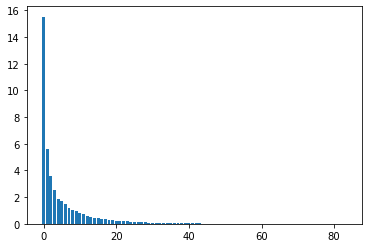

In [206]:
plt.bar(range(pca.n_components_),pca.explained_variance_) #variance explain vs pca_n

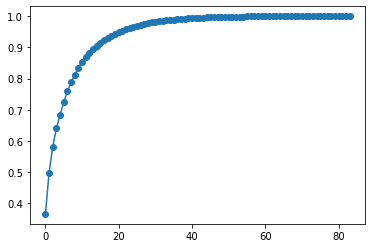

In [207]:
plt.plot(range(pca.n_components_),np.cumsum(pca.explained_variance_ratio_),marker='o')

In [208]:
#suppress scientific notation
np.set_printoptions(suppress=True)

In [209]:
pca.explained_variance_ratio_[:20]*100 

array([36.52271068, 13.19707391,  8.38356332,  5.9556022 ,  4.30482349,
        4.06394752,  3.47973676,  2.85987439,  2.42597449,  2.19240898,
        1.9259765 ,  1.72283938,  1.30279929,  1.11303457,  1.07656727,
        0.9596673 ,  0.8572806 ,  0.76561412,  0.61939994,  0.58435851])

In [210]:
np.cumsum(pca.explained_variance_ratio_)[:20]

array([0.36522711, 0.49719785, 0.58103348, 0.6405895 , 0.68363774,
       0.72427721, 0.75907458, 0.78767332, 0.81193307, 0.83385716,
       0.85311692, 0.87034532, 0.88337331, 0.89450365, 0.90526933,
       0.914866  , 0.92343881, 0.93109495, 0.93728895, 0.94313253])

iterate thourgh number of PCA to see the result of regressor score

In [211]:
#below cell take time to complete

In [212]:
#for i in range(1,20):
#    pca = PCA(n_components=i)
#    pca.fit(X)
#    X_pca = pca.transform(X)
#   rfr = RandomForestRegressor()
#    rfr.fit(X_pca,y)
#    r2_score = rfr.score(X_pca,y)
#    r2_cv_score = cross_val_score(rfr,X_pca,y,cv=5).mean()
#    print('n_component:',i)
#    print('ETR R2 Score:', r2_score)
#    print('ETR R2 CV Score:',r2_cv_score)
#    print('-----------------------')

In [213]:
print("""
n_component: 1
ETR R2 Score: 0.8222257049112671
ETR R2 CV Score: -4.873246284811646
-----------------------
n_component: 2
ETR R2 Score: 0.840139694124377
ETR R2 CV Score: -6.2768746033798175
-----------------------
n_component: 3
ETR R2 Score: 0.842085892749042
ETR R2 CV Score: -7.947774373533278
-----------------------
n_component: 4
ETR R2 Score: 0.8431446061119591
ETR R2 CV Score: -24.505155502131576
-----------------------
n_component: 5
ETR R2 Score: 0.8415405056851428
ETR R2 CV Score: -25.92569196793197
-----------------------
n_component: 6
ETR R2 Score: 0.8486767162267922
ETR R2 CV Score: -17.567711710076953
-----------------------
n_component: 7
ETR R2 Score: 0.8500564010955679
ETR R2 CV Score: -18.674887670005724
-----------------------
n_component: 8
ETR R2 Score: 0.8503223542044371
ETR R2 CV Score: -17.430493016780282
-----------------------
n_component: 9
ETR R2 Score: 0.8589974998197443
ETR R2 CV Score: -18.359418857641817
-----------------------
n_component: 10
ETR R2 Score: 0.8537877623144121
ETR R2 CV Score: -13.389008915322819
-----------------------
n_component: 11
ETR R2 Score: 0.84819324132689
ETR R2 CV Score: -16.106412367452233
-----------------------
n_component: 12
ETR R2 Score: 0.8644419993474624
ETR R2 CV Score: -45.286892002115486
-----------------------
n_component: 13
ETR R2 Score: 0.8529614253866731
ETR R2 CV Score: -43.32637063986889
-----------------------
n_component: 14
ETR R2 Score: 0.855762485666278
ETR R2 CV Score: -44.227106400143825
-----------------------
n_component: 15
ETR R2 Score: 0.8560603584862636
ETR R2 CV Score: -28.747854256281016
-----------------------
n_component: 16
ETR R2 Score: 0.8668654335365509
ETR R2 CV Score: -32.69160179748943
-----------------------
n_component: 17
ETR R2 Score: 0.8685591662471512
ETR R2 CV Score: -34.806006239957505
-----------------------
n_component: 18
ETR R2 Score: 0.8607459308200411
ETR R2 CV Score: -34.58748855900226
-----------------------
n_component: 19
ETR R2 Score: 0.8581672260420159
ETR R2 CV Score: -26.86728535431734
-----------------------
""")


n_component: 1
ETR R2 Score: 0.8222257049112671
ETR R2 CV Score: -4.873246284811646
-----------------------
n_component: 2
ETR R2 Score: 0.840139694124377
ETR R2 CV Score: -6.2768746033798175
-----------------------
n_component: 3
ETR R2 Score: 0.842085892749042
ETR R2 CV Score: -7.947774373533278
-----------------------
n_component: 4
ETR R2 Score: 0.8431446061119591
ETR R2 CV Score: -24.505155502131576
-----------------------
n_component: 5
ETR R2 Score: 0.8415405056851428
ETR R2 CV Score: -25.92569196793197
-----------------------
n_component: 6
ETR R2 Score: 0.8486767162267922
ETR R2 CV Score: -17.567711710076953
-----------------------
n_component: 7
ETR R2 Score: 0.8500564010955679
ETR R2 CV Score: -18.674887670005724
-----------------------
n_component: 8
ETR R2 Score: 0.8503223542044371
ETR R2 CV Score: -17.430493016780282
-----------------------
n_component: 9
ETR R2 Score: 0.8589974998197443
ETR R2 CV Score: -18.359418857641817
-----------------------
n_component: 10
ETR R2 

Choosing n_component =1 with acceptable accuracy + lowest variance

In [214]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
rfr = RandomForestRegressor()
rfr.fit(X_pca,y)

RandomForestRegressor()

In [215]:
#predict nummos for test
X_test = test_final.drop(columns=['id', 'date','UNSPECIFIED CULEX'])
X_test_pca = pca.transform(X_test) # no mosquitos
test_final['nummosquitos'] = rfr.predict(X_test_pca)

### Predict WNVpresent

**using PCA**

In [216]:
X = train_final.drop(columns=['wnvpresent'])
y = train_final.wnvpresent
pd.Series(y).value_counts()

0    8018
1     457
Name: wnvpresent, dtype: int64

In [217]:
#do PCA
pca = PCA()
pca.fit(X)

PCA()

In [218]:
np.cumsum(pca.explained_variance_ratio_)

array([0.99253196, 0.99525281, 0.99623955, 0.99686657, 0.99731208,
       0.99763405, 0.99793807, 0.99819836, 0.99841229, 0.99859373,
       0.99875757, 0.99890164, 0.99903052, 0.99912797, 0.99921122,
       0.99929175, 0.99936355, 0.99942764, 0.99948492, 0.99953125,
       0.99957492, 0.99961569, 0.99965446, 0.99968981, 0.99972034,
       0.99974857, 0.99977294, 0.99979435, 0.99981434, 0.99983399,
       0.99985065, 0.99986454, 0.99987781, 0.99988976, 0.99990139,
       0.99991122, 0.99991962, 0.99992746, 0.99993478, 0.99994178,
       0.99994778, 0.99995352, 0.99995872, 0.99996331, 0.99996769,
       0.99997164, 0.99997513, 0.99997793, 0.99998054, 0.99998306,
       0.99998521, 0.99998728, 0.99998898, 0.99999063, 0.99999196,
       0.99999318, 0.99999411, 0.99999497, 0.99999573, 0.99999631,
       0.99999688, 0.99999742, 0.99999789, 0.99999831, 0.99999868,
       0.99999901, 0.99999927, 0.99999948, 0.99999964, 0.99999979,
       0.9999999 , 0.99999998, 1.        , 1.        , 1.     

choosing n=1

In [219]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)

In [220]:
X_test = test_final.drop(columns=['id', 'date','UNSPECIFIED CULEX'])
X_test_pca = pca.transform(X_test)

In [221]:
#classification
#Train-test
X_train,X_val,y_train,y_val = train_test_split(X_pca,y,stratify=y,random_state=42)
#SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train,y_train)

pd.Series(y_train_sm).value_counts()

1    6013
0    6013
Name: wnvpresent, dtype: int64

In [222]:
#create classificationmodel
gbc =GradientBoostingClassifier(random_state=42)
gbc.fit(X_train_sm,y_train_sm)
#check score
roc_auc_score(y_val,gbc.predict_proba(X_val)[:,1])

0.8262042262764142

In [223]:
#predict wnvpresent
ypred = gbc.predict(X_test_pca)
pd.Series(ypred).value_counts()

0    115827
1       466
dtype: int64

In [224]:
#create submit
ypred_prob = gbc.predict_proba(X_test_pca)
submit = pd.DataFrame()
submit['Id'] = test_final.id
submit['WnvPresent'] = [x[1] for x in ypred_prob]

#write to csv
submit.to_csv('model_1_with_pca.csv',index=False)

submit.head()

,Id,WnvPresent
0,1,0.025924
1,2,0.025924
2,3,0.025924
3,4,0.025924
4,5,0.025924


**Private Score: 0.49967**

**Not Using PCA**

In [225]:
X = train_final.drop(columns=['wnvpresent'])
y = train_final.wnvpresent
pd.Series(y).value_counts()

0    8018
1     457
Name: wnvpresent, dtype: int64

In [226]:
#classification
#Train-test
X_train,X_val,y_train,y_val = train_test_split(X,y,stratify=y,random_state=42)
#SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train,y_train)

pd.Series(y_train_sm).value_counts()

1    6013
0    6013
Name: wnvpresent, dtype: int64

In [227]:
#create classificationmodel
gbc =GradientBoostingClassifier(random_state=42)
gbc.fit(X_train_sm,y_train_sm)
#check score
roc_auc_score(y_val,gbc.predict_proba(X_val)[:,1])

0.8728857680360502

In [228]:
#predict wnvpresent
X_test = test_final.drop(columns=['id', 'date','UNSPECIFIED CULEX'])
ypred = gbc.predict(X_test)
pd.Series(ypred).value_counts()

0    90611
1    25682
dtype: int64

In [229]:
#create submit
ypred_prob = gbc.predict_proba(X_test)
submit = pd.DataFrame()
submit['Id'] = test_final.id
submit['WnvPresent'] = [x[1] for x in ypred_prob]

#write to csv
submit.to_csv('model_1_no_pca.csv',index=False)

submit.head()

,Id,WnvPresent
0,1,0.191400
1,2,0.230084
2,3,0.666615
3,4,0.167513
4,5,0.666615


**Private Score: 0.47090**

## Model 2: Use only features in train datasets

Avoid using weather data since it can negatively impact model due to its low accuracy to each trap.

In [230]:
train_final['date'] = train_weather.index
train_final.head()

,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,...,codesum_2_FG+,codesum_2_FU,codesum_2_HZ,codesum_2_MIFG,codesum_2_RA,codesum_2_TS,codesum_2_TSRA,codesum_2_VCFG,codesum_2_VCTS,date
0,0.78814,0.197589,0.569888,-0.025491,0.233117,-0.345897,0.582518,-0.413861,1.22047,1.084001,...,0,0,0,0,1,0,0,0,0,2007-05-29
1,0.78814,0.197589,0.569888,-0.025491,0.233117,-0.345897,0.582518,-0.413861,1.22047,1.084001,...,0,0,0,0,1,0,0,0,0,2007-05-29
2,0.78814,0.197589,0.569888,-0.025491,0.233117,-0.345897,0.582518,-0.413861,1.22047,1.084001,...,0,0,0,0,1,0,0,0,0,2007-05-29
3,0.78814,0.197589,0.569888,-0.025491,0.233117,-0.345897,0.582518,-0.413861,1.22047,1.084001,...,0,0,0,0,1,0,0,0,0,2007-05-29
4,0.78814,0.197589,0.569888,-0.025491,0.233117,-0.345897,0.582518,-0.413861,1.22047,1.084001,...,0,0,0,0,1,0,0,0,0,2007-05-29


Obtain week and year to use as seasonality features

In [231]:
train_final['week'] = train_final.date.dt.week
train_final['year'] = train_final.date.dt.year
train_final.head()

<ipython-input-231-6c7fbe60854b>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_final['week'] = train_final.date.dt.week


,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,...,codesum_2_HZ,codesum_2_MIFG,codesum_2_RA,codesum_2_TS,codesum_2_TSRA,codesum_2_VCFG,codesum_2_VCTS,date,week,year
0,0.78814,0.197589,0.569888,-0.025491,0.233117,-0.345897,0.582518,-0.413861,1.22047,1.084001,...,0,0,1,0,0,0,0,2007-05-29,22,2007
1,0.78814,0.197589,0.569888,-0.025491,0.233117,-0.345897,0.582518,-0.413861,1.22047,1.084001,...,0,0,1,0,0,0,0,2007-05-29,22,2007
2,0.78814,0.197589,0.569888,-0.025491,0.233117,-0.345897,0.582518,-0.413861,1.22047,1.084001,...,0,0,1,0,0,0,0,2007-05-29,22,2007
3,0.78814,0.197589,0.569888,-0.025491,0.233117,-0.345897,0.582518,-0.413861,1.22047,1.084001,...,0,0,1,0,0,0,0,2007-05-29,22,2007
4,0.78814,0.197589,0.569888,-0.025491,0.233117,-0.345897,0.582518,-0.413861,1.22047,1.084001,...,0,0,1,0,0,0,0,2007-05-29,22,2007


In [232]:
test_final['date'] = pd.to_datetime(test_final.date)
test_final['week'] = test_final.date.dt.week
test_final['year'] = test_final.date.dt.year
test_final.head()

<ipython-input-232-d0e89eff6fb5>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test_final['week'] = test_final.date.dt.week


,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,...,codesum_2_HZ,codesum_2_MIFG,codesum_2_RA,codesum_2_TS,codesum_2_TSRA,codesum_2_VCFG,codesum_2_VCTS,nummosquitos,week,year
0,0.550828,-0.320611,0.176998,-0.400764,-0.060096,-0.345897,0.065499,-0.413861,-0.10861,0.255276,...,0,0,1,0,0,0,0,2.72,24,2008
1,0.550828,-0.320611,0.176998,-0.400764,-0.060096,-0.345897,0.065499,-0.413861,-0.10861,0.255276,...,0,0,1,0,0,0,0,2.72,24,2008
2,0.550828,-0.320611,0.176998,-0.400764,-0.060096,-0.345897,0.065499,-0.413861,-0.10861,0.255276,...,0,0,1,0,0,0,0,78.71,24,2008
3,0.550828,-0.320611,0.176998,-0.400764,-0.060096,-0.345897,0.065499,-0.413861,-0.10861,0.255276,...,0,0,1,0,0,0,0,2.72,24,2008
4,0.550828,-0.320611,0.176998,-0.400764,-0.060096,-0.345897,0.065499,-0.413861,-0.10861,0.255276,...,0,0,1,0,0,0,0,2.72,24,2008


In [233]:
train_final.columns

Index(['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed', 'tmax-1', 'tmin-1', 'tavg-1', 'dewpoint-1', 'wetbulb-1',
       'heat-1', 'cool-1', 'preciptotal-1', 'stnpressure-1', 'sealevel-1',
       'resultspeed-1', 'resultdir-1', 'avgspeed-1', 'tmax-2', 'tmin-2',
       'tavg-2', 'dewpoint-2', 'wetbulb-2', 'heat-2', 'cool-2',
       'preciptotal-2', 'stnpressure-2', 'sealevel-2', 'resultspeed-2',
       'resultdir-2', 'avgspeed-2', 'lat', 'long', 'nummosquitos',
       'wnvpresent', 'CULEX ERRATICUS', 'CULEX PIPIENS',
       'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX SALINARIUS',
       'CULEX TARSALIS', 'CULEX TERRITANS', 'codesum_BR', 'codesum_DZ',
       'codesum_FG', 'codesum_FG+', 'codesum_FU', 'codesum_HZ', 'codesum_MIFG',
       'codesum_RA', 'codesum_TS', 'codesum_TSRA', 'codesum_VCFG',
       'codesum_VCTS', 'codesum_1_BR', 'codesum_1_DZ', 'codesum_1_FG',
       '

**regression**

In [234]:
train_final.columns

Index(['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed', 'tmax-1', 'tmin-1', 'tavg-1', 'dewpoint-1', 'wetbulb-1',
       'heat-1', 'cool-1', 'preciptotal-1', 'stnpressure-1', 'sealevel-1',
       'resultspeed-1', 'resultdir-1', 'avgspeed-1', 'tmax-2', 'tmin-2',
       'tavg-2', 'dewpoint-2', 'wetbulb-2', 'heat-2', 'cool-2',
       'preciptotal-2', 'stnpressure-2', 'sealevel-2', 'resultspeed-2',
       'resultdir-2', 'avgspeed-2', 'lat', 'long', 'nummosquitos',
       'wnvpresent', 'CULEX ERRATICUS', 'CULEX PIPIENS',
       'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX SALINARIUS',
       'CULEX TARSALIS', 'CULEX TERRITANS', 'codesum_BR', 'codesum_DZ',
       'codesum_FG', 'codesum_FG+', 'codesum_FU', 'codesum_HZ', 'codesum_MIFG',
       'codesum_RA', 'codesum_TS', 'codesum_TSRA', 'codesum_VCFG',
       'codesum_VCTS', 'codesum_1_BR', 'codesum_1_DZ', 'codesum_1_FG',
       '

In [235]:
#select features for regression part
X = train_final[['week', 'year','CULEX ERRATICUS', 'CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS',
       'CULEX RESTUANS', 'CULEX SALINARIUS', 'CULEX TARSALIS',
       'CULEX TERRITANS', 'lat', 'long']]
y = train_final.nummosquitos
X

,week,year,CULEX ERRATICUS,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX SALINARIUS,CULEX TARSALIS,CULEX TERRITANS,lat,long
0,22,2007,0,1,0,0,0,0,0,41.731922,-87.677512
1,22,2007,0,0,1,0,0,0,0,41.867108,-87.654224
2,22,2007,0,0,1,0,0,0,0,41.919343,-87.694259
3,22,2007,0,0,1,0,0,0,0,41.921965,-87.632085
4,22,2007,0,0,1,0,0,0,0,41.688324,-87.676709
...,...,...,...,...,...,...,...,...,...,...,...
8470,39,2013,0,0,0,1,0,0,0,41.867108,-87.654224
8471,39,2013,0,0,0,1,0,0,0,41.803423,-87.642984
8472,39,2013,0,0,0,1,0,0,0,41.750498,-87.605294
8473,39,2013,0,0,0,1,0,0,0,41.740641,-87.546587


In [236]:
X_test = test_final[['week', 'year', 'CULEX ERRATICUS','CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS',
       'CULEX RESTUANS', 'CULEX SALINARIUS', 'CULEX TARSALIS',
       'CULEX TERRITANS', 'lat', 'long']]

In [237]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X,y)
r2_score = rfr.score(X,y)
r2_cv_score = cross_val_score(rfr,X,y,cv=5).mean()
rmse_score = np.abs(cross_val_score(rfr,X,y,cv=5,scoring='neg_root_mean_squared_error').mean())
print('RFR R2 Score:', r2_score)
print('RFR R2 CV Score:',r2_cv_score)
print('RFR RMSE Score:', rmse_score)


RFR R2 Score: 0.7868134794224533
RFR R2 CV Score: -0.07784764705604297
RFR RMSE Score: 61.2490713036947


In [238]:
test_final['nummosquitos'] = rfr.predict(X_test)

In [239]:
test_final.nummosquitos

0         2.816667
1         5.210000
2         2.593333
3         4.170000
4         4.403333
            ...   
116288    5.690000
116289    5.690000
116290    5.690000
116291    5.690000
116292    5.690000
Name: nummosquitos, Length: 116293, dtype: float64

**classification**

In [240]:
#select feature for classification part
X = train_final[['week', 'year', 'CULEX ERRATICUS','CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS',
       'CULEX RESTUANS', 'CULEX SALINARIUS', 'CULEX TARSALIS',
       'CULEX TERRITANS', 'lat', 'long','nummosquitos']]
y = train_final.wnvpresent
pd.Series(y).value_counts()

0    8018
1     457
Name: wnvpresent, dtype: int64

In [241]:
X_test = test_final[['week', 'year','CULEX ERRATICUS', 'CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS',
       'CULEX RESTUANS', 'CULEX SALINARIUS', 'CULEX TARSALIS',
       'CULEX TERRITANS', 'lat', 'long','nummosquitos']]

In [242]:
#classificatin
#Train-test
X_train,X_val,y_train,y_val = train_test_split(X,y,stratify=y,random_state=42)
#SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train,y_train)

pd.Series(y_train_sm).value_counts()

1    6013
0    6013
Name: wnvpresent, dtype: int64

In [243]:
#create classificationmodel
gbc =GradientBoostingClassifier()
gbc.fit(X_train_sm,y_train_sm)
#check score
roc_auc_score(y_val,gbc.predict_proba(X_val)[:,1]) 

0.889716498228114

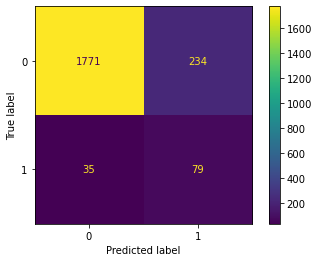

In [244]:
plot_confusion_matrix(gbc,X_val,y_val)

In [245]:
#predict wnvpresent
ypred = gbc.predict(X_test)
pd.Series(ypred).value_counts()

0    76438
1    39855
dtype: int64

In [246]:
#create submit
ypred_prob = gbc.predict_proba(X_test)
submit = pd.DataFrame()
submit['Id'] = test_final.id
submit['WnvPresent'] = [x[1] for x in ypred_prob]

#write to csv
submit.to_csv('model_2.csv',index=False)

submit.head()

,Id,WnvPresent
0,1,0.031575
1,2,0.022830
2,3,0.045777
3,4,0.126993
4,5,0.066953


**Private Score: 0.75545**

## Model 3: try to improve model 2 with some additional features

In [291]:
train_final.columns

Index(['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed', 'tmax-1', 'tmin-1', 'tavg-1', 'dewpoint-1', 'wetbulb-1',
       'heat-1', 'cool-1', 'preciptotal-1', 'stnpressure-1', 'sealevel-1',
       'resultspeed-1', 'resultdir-1', 'avgspeed-1', 'tmax-2', 'tmin-2',
       'tavg-2', 'dewpoint-2', 'wetbulb-2', 'heat-2', 'cool-2',
       'preciptotal-2', 'stnpressure-2', 'sealevel-2', 'resultspeed-2',
       'resultdir-2', 'avgspeed-2', 'lat', 'long', 'nummosquitos',
       'wnvpresent', 'CULEX ERRATICUS', 'CULEX PIPIENS',
       'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX SALINARIUS',
       'CULEX TARSALIS', 'CULEX TERRITANS', 'codesum_BR', 'codesum_DZ',
       'codesum_FG', 'codesum_FG+', 'codesum_FU', 'codesum_HZ', 'codesum_MIFG',
       'codesum_RA', 'codesum_TS', 'codesum_TSRA', 'codesum_VCFG',
       'codesum_VCTS', 'codesum_1_BR', 'codesum_1_DZ', 'codesum_1_FG',
       '

**feature selection**

In [292]:
add_feature =  ['tavg','dewpoint']
select_feature = ['week', 'year', 'CULEX ERRATICUS','CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS',
       'CULEX RESTUANS', 'CULEX SALINARIUS', 'CULEX TARSALIS',
       'CULEX TERRITANS', 'lat', 'long'] + add_feature

select_feature

['week',
 'year',
 'CULEX ERRATICUS',
 'CULEX PIPIENS',
 'CULEX PIPIENS/RESTUANS',
 'CULEX RESTUANS',
 'CULEX SALINARIUS',
 'CULEX TARSALIS',
 'CULEX TERRITANS',
 'lat',
 'long',
 'tavg',
 'dewpoint']

**regression**

In [293]:
#define X,y
X = train_final[select_feature]
y = train_final.nummosquitos
X_test = test_final[select_feature]

#regression
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X,y)
r2_score = rfr.score(X,y)
#r2_cv_score = cross_val_score(rfr,X,y,cv=5).mean()
#rmse_score = np.abs(cross_val_score(rfr,X,y,cv=5,scoring='neg_root_mean_squared_error').mean())
print('RFR R2 Score:', r2_score)
print('RFR R2 CV Score:',r2_cv_score)
print('RFR RMSE Score:', rmse_score)

#predict nummosquitos
test_final['nummosquitos'] = rfr.predict(X_test)

RFR R2 Score: 0.9062132222161853
RFR R2 CV Score: -0.07784764705604297
RFR RMSE Score: 61.2490713036947


**classification**

In [294]:
#select feature for classification part
select_feature += ['nummosquitos']
X = train_final[select_feature]
y = train_final.wnvpresent
X_test = test_final[select_feature]

#classificatin
#Train-test
X_train,X_val,y_train,y_val = train_test_split(X,y,stratify=y,random_state=42)
#SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train,y_train)

#create classificationmodel
gbc =GradientBoostingClassifier(random_state=42)
gbc.fit(X_train_sm,y_train_sm)
#check score
print('Recall Score:',recall_score(y_val,gbc.predict(X_val))) 
print('ROC_AUC Score:',roc_auc_score(y_val,gbc.predict_proba(X_val)[:,1])) 

Recall Score: 0.6491228070175439
ROC_AUC Score: 0.8876821105131907


**plot confusion matrix**

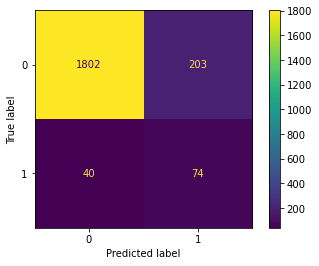

In [295]:
plot_confusion_matrix(gbc,X_val,y_val)

**plot roc_auc curve**

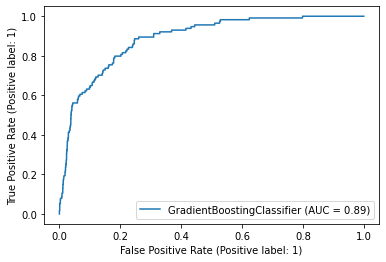

In [296]:
plot_roc_curve(gbc,X_val,y_val)

**predict and write to file**

In [297]:
#predict wnvpresent
ypred = gbc.predict(X_test)
pd.Series(ypred).value_counts()

0    78654
1    37639
dtype: int64

In [298]:
#create submit
ypred_prob = gbc.predict_proba(X_test)
submit = pd.DataFrame()
submit['Id'] = test_final.id
submit['WnvPresent'] = [x[1] for x in ypred_prob]

#write to csv
submit.to_csv('model_3.csv',index=False)

submit.head()

,Id,WnvPresent
0,1,0.034950
1,2,0.046418
2,3,0.057158
3,4,0.149955
4,5,0.073980


**Private Score: 0.76695**

## Tuning Hyperparameter

In [299]:
add_feature =  ['tavg','dewpoint']
select_feature = ['week', 'year', 'CULEX ERRATICUS','CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS',
       'CULEX RESTUANS', 'CULEX SALINARIUS', 'CULEX TARSALIS',
       'CULEX TERRITANS', 'lat', 'long'] + add_feature

select_feature

['week',
 'year',
 'CULEX ERRATICUS',
 'CULEX PIPIENS',
 'CULEX PIPIENS/RESTUANS',
 'CULEX RESTUANS',
 'CULEX SALINARIUS',
 'CULEX TARSALIS',
 'CULEX TERRITANS',
 'lat',
 'long',
 'tavg',
 'dewpoint']

**Tuning RandomForestRegressor**

In [300]:
#define X,y
X = train_final[select_feature]
y = train_final.nummosquitos
X_test = test_final[select_feature]

In [301]:
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [302]:
params = {
    'max_depth':[None,5,10],
    'n_estimators': [50,100,200]
}

In [303]:
gs = GridSearchCV(RandomForestRegressor(random_state=42),param_grid=params)
gs.fit(X,y)

GridSearchCV(estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [304]:
gs.best_params_

{'max_depth': 5, 'n_estimators': 200}

**use param from gridsearch**

In [305]:
#define X,y
X = train_final[select_feature]
y = train_final.nummosquitos
X_test = test_final[select_feature]

#regression
rfr = RandomForestRegressor(n_estimators=200, random_state=42, max_depth= 10)
rfr.fit(X,y)
r2_score = rfr.score(X,y)
#r2_cv_score = cross_val_score(rfr,X,y,cv=5).mean()
#rmse_score = np.abs(cross_val_score(rfr,X,y,cv=5,scoring='neg_root_mean_squared_error').mean())
print('RFR R2 Score:', r2_score)
print('RFR R2 CV Score:',r2_cv_score)
print('RFR RMSE Score:', rmse_score)

#predict nummosquitos
test_final['nummosquitos'] = rfr.predict(X_test)

RFR R2 Score: 0.8694199649065979
RFR R2 CV Score: -0.07784764705604297
RFR RMSE Score: 61.2490713036947


**tuning SMOTE**

In [327]:
from imblearn.pipeline import Pipeline

pipe = Pipeline([('sm', SMOTE()),
    ('gbc', GradientBoostingClassifier())
    ])

pipe.get_params()

{'memory': None,
 'steps': [('sm', SMOTE()), ('gbc', GradientBoostingClassifier())],
 'verbose': False,
 'sm': SMOTE(),
 'gbc': GradientBoostingClassifier(),
 'sm__k_neighbors': 5,
 'sm__n_jobs': None,
 'sm__random_state': None,
 'sm__sampling_strategy': 'auto',
 'gbc__ccp_alpha': 0.0,
 'gbc__criterion': 'friedman_mse',
 'gbc__init': None,
 'gbc__learning_rate': 0.1,
 'gbc__loss': 'deviance',
 'gbc__max_depth': 3,
 'gbc__max_features': None,
 'gbc__max_leaf_nodes': None,
 'gbc__min_impurity_decrease': 0.0,
 'gbc__min_impurity_split': None,
 'gbc__min_samples_leaf': 1,
 'gbc__min_samples_split': 2,
 'gbc__min_weight_fraction_leaf': 0.0,
 'gbc__n_estimators': 100,
 'gbc__n_iter_no_change': None,
 'gbc__random_state': None,
 'gbc__subsample': 1.0,
 'gbc__tol': 0.0001,
 'gbc__validation_fraction': 0.1,
 'gbc__verbose': 0,
 'gbc__warm_start': False}

In [328]:
#define params used for gridsearch
pipe_params = {
    'sm__sampling_strategy': ['auto','all'],
    'sm__k_neighbors': [3, 5,7,9]
}

to prevent long computing time, only doing smote only

In [330]:
#select feature for classification part
add_feature =  ['tavg','dewpoint']
select_feature = ['week', 'year', 'CULEX ERRATICUS','CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS',
       'CULEX RESTUANS', 'CULEX SALINARIUS', 'CULEX TARSALIS',
       'CULEX TERRITANS', 'lat', 'long'] + add_feature
select_feature += ['nummosquitos']
X = train_final[select_feature]
y = train_final.wnvpresent
X_test = test_final[select_feature]

#classificatin
#Train-test
X_train,X_val,y_train,y_val = train_test_split(X,y,stratify=y,random_state=42)

gs = GridSearchCV(pipe,param_grid=pipe_params,verbose=2,scoring='roc_auc')
gs.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ......sm__k_neighbors=3, sm__sampling_strategy=auto; total time=   1.0s
[CV] END ......sm__k_neighbors=3, sm__sampling_strategy=auto; total time=   1.0s
[CV] END ......sm__k_neighbors=3, sm__sampling_strategy=auto; total time=   1.0s
[CV] END ......sm__k_neighbors=3, sm__sampling_strategy=auto; total time=   1.0s
[CV] END ......sm__k_neighbors=3, sm__sampling_strategy=auto; total time=   1.0s
[CV] END .......sm__k_neighbors=3, sm__sampling_strategy=all; total time=   1.0s
[CV] END .......sm__k_neighbors=3, sm__sampling_strategy=all; total time=   1.0s
[CV] END .......sm__k_neighbors=3, sm__sampling_strategy=all; total time=   1.0s
[CV] END .......sm__k_neighbors=3, sm__sampling_strategy=all; total time=   1.0s
[CV] END .......sm__k_neighbors=3, sm__sampling_strategy=all; total time=   1.0s
[CV] END ......sm__k_neighbors=5, sm__sampling_strategy=auto; total time=   1.0s
[CV] END ......sm__k_neighbors=5, sm__sampling_st

GridSearchCV(estimator=Pipeline(steps=[('sm', SMOTE()),
                                       ('gbc', GradientBoostingClassifier())]),
             param_grid={'sm__k_neighbors': [3, 5, 7, 9],
                         'sm__sampling_strategy': ['auto', 'all']},
             scoring='roc_auc', verbose=2)

In [333]:
gs.best_score_

0.8797854437912308

In [334]:
gs.best_params_

{'sm__k_neighbors': 7, 'sm__sampling_strategy': 'all'}

**tuning gbc**

In [338]:
#define params used for gridsearch
pipe_params = {
    'gbc__max_depth' : [3,5,7],
    'gbc__n_estimators': [100,200],
    'gbc__learning_rate':[0.05,0.1,0.5]
}

In [339]:
pipe = Pipeline([('sm', SMOTE(k_neighbors=7,sampling_strategy='all')),
    ('gbc', GradientBoostingClassifier())
    ])

pipe.get_params()

{'memory': None,
 'steps': [('sm', SMOTE(k_neighbors=7, sampling_strategy='all')),
  ('gbc', GradientBoostingClassifier())],
 'verbose': False,
 'sm': SMOTE(k_neighbors=7, sampling_strategy='all'),
 'gbc': GradientBoostingClassifier(),
 'sm__k_neighbors': 7,
 'sm__n_jobs': None,
 'sm__random_state': None,
 'sm__sampling_strategy': 'all',
 'gbc__ccp_alpha': 0.0,
 'gbc__criterion': 'friedman_mse',
 'gbc__init': None,
 'gbc__learning_rate': 0.1,
 'gbc__loss': 'deviance',
 'gbc__max_depth': 3,
 'gbc__max_features': None,
 'gbc__max_leaf_nodes': None,
 'gbc__min_impurity_decrease': 0.0,
 'gbc__min_impurity_split': None,
 'gbc__min_samples_leaf': 1,
 'gbc__min_samples_split': 2,
 'gbc__min_weight_fraction_leaf': 0.0,
 'gbc__n_estimators': 100,
 'gbc__n_iter_no_change': None,
 'gbc__random_state': None,
 'gbc__subsample': 1.0,
 'gbc__tol': 0.0001,
 'gbc__validation_fraction': 0.1,
 'gbc__verbose': 0,
 'gbc__warm_start': False}

In [340]:
#select feature for classification part
add_feature =  ['tavg','dewpoint']
select_feature = ['week', 'year', 'CULEX ERRATICUS','CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS',
       'CULEX RESTUANS', 'CULEX SALINARIUS', 'CULEX TARSALIS',
       'CULEX TERRITANS', 'lat', 'long'] + add_feature
select_feature += ['nummosquitos']
X = train_final[select_feature]
y = train_final.wnvpresent
X_test = test_final[select_feature]

#classificatin
#Train-test
X_train,X_val,y_train,y_val = train_test_split(X,y,stratify=y,random_state=42)

gs2 = GridSearchCV(pipe,param_grid=pipe_params,verbose=2,scoring='roc_auc')
gs2.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END gbc__learning_rate=0.05, gbc__max_depth=3, gbc__n_estimators=100; total time=   1.0s
[CV] END gbc__learning_rate=0.05, gbc__max_depth=3, gbc__n_estimators=100; total time=   1.0s
[CV] END gbc__learning_rate=0.05, gbc__max_depth=3, gbc__n_estimators=100; total time=   1.0s
[CV] END gbc__learning_rate=0.05, gbc__max_depth=3, gbc__n_estimators=100; total time=   1.0s
[CV] END gbc__learning_rate=0.05, gbc__max_depth=3, gbc__n_estimators=100; total time=   1.0s
[CV] END gbc__learning_rate=0.05, gbc__max_depth=3, gbc__n_estimators=200; total time=   2.1s
[CV] END gbc__learning_rate=0.05, gbc__max_depth=3, gbc__n_estimators=200; total time=   2.1s
[CV] END gbc__learning_rate=0.05, gbc__max_depth=3, gbc__n_estimators=200; total time=   2.1s
[CV] END gbc__learning_rate=0.05, gbc__max_depth=3, gbc__n_estimators=200; total time=   2.1s
[CV] END gbc__learning_rate=0.05, gbc__max_depth=3, gbc__n_estimators=200; total time=   2.1s

[CV] END gbc__learning_rate=0.5, gbc__max_depth=7, gbc__n_estimators=200; total time=   5.2s
[CV] END gbc__learning_rate=0.5, gbc__max_depth=7, gbc__n_estimators=200; total time=   5.4s


GridSearchCV(estimator=Pipeline(steps=[('sm',
                                        SMOTE(k_neighbors=7,
                                              sampling_strategy='all')),
                                       ('gbc', GradientBoostingClassifier())]),
             param_grid={'gbc__learning_rate': [0.05, 0.1, 0.5],
                         'gbc__max_depth': [3, 5, 7],
                         'gbc__n_estimators': [100, 200]},
             scoring='roc_auc', verbose=2)

In [341]:
gs2.best_score_

0.8788654380635806

In [343]:
gs2.best_params_

{'gbc__learning_rate': 0.05, 'gbc__max_depth': 3, 'gbc__n_estimators': 100}

## Model 4: Using hyperparameter

**feature selection**

In [344]:
add_feature =  ['tavg','dewpoint']
select_feature = ['week', 'year', 'CULEX ERRATICUS','CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS',
       'CULEX RESTUANS', 'CULEX SALINARIUS', 'CULEX TARSALIS',
       'CULEX TERRITANS', 'lat', 'long'] + add_feature

select_feature

['week',
 'year',
 'CULEX ERRATICUS',
 'CULEX PIPIENS',
 'CULEX PIPIENS/RESTUANS',
 'CULEX RESTUANS',
 'CULEX SALINARIUS',
 'CULEX TARSALIS',
 'CULEX TERRITANS',
 'lat',
 'long',
 'tavg',
 'dewpoint']

**regression**: using {'max_depth': 5, 'n_estimators': 200}

In [345]:
#define X,y
X = train_final[select_feature]
y = train_final.nummosquitos
X_test = test_final[select_feature]

#regression
rfr = RandomForestRegressor(random_state=42,max_depth=5,n_estimators=200)
rfr.fit(X,y)

#predict nummosquitos
test_final['nummosquitos'] = rfr.predict(X_test)

**classification**: 

{'sm__k_neighbors': 7, 'sm__sampling_strategy': 'all'} & 

{'gbc__learning_rate': 0.05, 'gbc__max_depth': 3, 'gbc__n_estimators': 100}

In [346]:
#select feature for classification part
select_feature += ['nummosquitos']
X = train_final[select_feature]
y = train_final.wnvpresent
X_test = test_final[select_feature]

#classificatin
#Train-test
X_train,X_val,y_train,y_val = train_test_split(X,y,stratify=y,random_state=42)
#SMOTE
sm = SMOTE(random_state=42,k_neighbors=7,sampling_strategy='all')
X_train_sm, y_train_sm = sm.fit_resample(X_train,y_train)

#create classificationmodel
gbc =GradientBoostingClassifier(learning_rate=0.05)
gbc.fit(X_train_sm,y_train_sm)
#check score
print('Recall Score:',recall_score(y_val,gbc.predict(X_val))) 
print('ROC_AUC Score:',roc_auc_score(y_val,gbc.predict_proba(X_val)[:,1])) 

Recall Score: 0.7105263157894737
ROC_AUC Score: 0.8902786892418078


In [347]:
pd.Series(y_train_sm).value_counts()

1    6013
0    6013
Name: wnvpresent, dtype: int64

**plot confusion matrix**

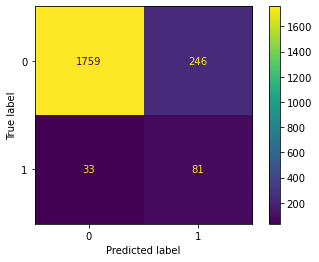

In [348]:
plot_confusion_matrix(gbc,X_val,y_val)

**plot roc curve**

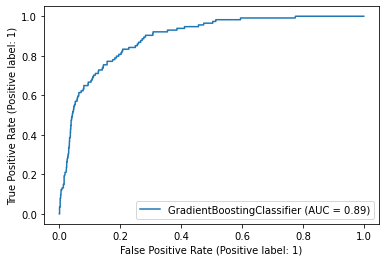

In [349]:
plot_roc_curve(gbc,X_val,y_val)

**predict and write to file**

In [350]:
#predict wnvpresent
ypred = gbc.predict(X_test)
pd.Series(ypred).value_counts()

0    67273
1    49020
dtype: int64

In [351]:
#create submit
ypred_prob = gbc.predict_proba(X_test)
submit = pd.DataFrame()
submit['Id'] = test_final.id
submit['WnvPresent'] = [x[1] for x in ypred_prob]

#write to csv
submit.to_csv('model_4_hyper.csv',index=False)

submit.head()

,Id,WnvPresent
0,1,0.053964
1,2,0.038531
2,3,0.093050
3,4,0.260067
4,5,0.132294


**Private Score: 0.71512**

# Result and Discussion

| Model | Features | PCA | nummosquitos/Regressor | Classification Model | Validating Roc_auc Score | Kaggle Score |
|-|-|-|-|-|-|-|
| 0 | All | Yes | No/- | RandomForestClassifier | 0.6212 | 0.5829 |
| 1.1 | All | Yes | Yes/RandomForest | GradientBoostingClassifier | 0.8262 | 0.4996 |
| 1.2 | All | No | Yes/RandomForest | GradientBoostingClassifier | 0.8728 | 0.4709 |
| 2 | Species,Date,Location | No | Yes/RandomForest | GradientBoostingClassifier | 0.8897 | 0.7554 |
| 3 | Species,Date,Location + AverageTemp,Dewpoint | No | Yes/RandomForest | GradientBoostingClassifier | 0.8876 | 0.7669 |
| 4* | Species,Date,Location + AverageTemp,Dewpoint | No | Yes/RandomForest | GradientBoostingClassifier (tuning hyper parameter) | 0.8902 | 0.7151 |

**Discussion**

4 Models were built in this project and the model which performs best in kaggle competition is model 3 which is based on model 2. The features used in model 3 consist of 

- `Species` -> treated as a dummy variables
- `Dates` -> week and year
- `Location` -> latitude,longitude
- `Weather Data` -> Average temperature and Dew point temperature

The idea behind model 1 is that all the features should be included and the weather data from $t_{-1}$ and $t_{-2}$ are also added to the main dataset,however, result showed that the score is much lower than the small subset of features in model 2 and 3. This could be caused by the fact that West Nile Virus is a seasonal virus and all the weather data can be neglected since there are also temporal features in the main datasets. From EDA, we can see that all the years (2009-2013), temperatures shows the cycle of seasonal trends and did not change much even from the global warming. Thus, when many features are used and most of them cannot make any impact on predicting the presence of virus, the model becomes inaccurate. 

Moreover, the weather-related features we got is only from `station1` and `station2` which is not exclusive to each traps thus could lower the accuracy. Surprsingly,`week` can be effectively infered to local weather data due to weather's seasonality.

**Improvement**

To improve roc auc score, the following features could be explore:

- Moving average of weather features
- Iterate through weather datasets to see that weather from 'x' days ago can impact the presence of virus
- Spray impact that might be left io the traps exposed by the chemical


# Conclusion and Recommendation

**Conclusion:**

The best features that can be used for predicting mosquito infected by West Nile Virus are

1. Week Number - indicates the season and time of the year
2. Year - indicates the changes that happen in each year
3. Mosquito Species
4. Latitude and Longitude - approximate locations of where the virus was present
5. Tavg - Average temperature
6. Dewpoint - Temperature to which air must be cooled to become saturated with water vapor.

Our model also yields a high accuracy score of 89%, with low misclassification score of about 11%.
Since the aim of doing this project is to reduce the chance of people being infected by mosquito that carry the West Nile Virus, we should be focusing on reducing the False Negatives. In doing so, we would predict that virus is present even though it might not be present, in other words, increasing False Positives.


In trying to reduce False Negatives, this would mean that an increase in spraying would be needed even though it might not be necessary, thus increase the cost of the city.
By spraying these pesticides, people would be advised to stay home, meaning they would have to know about the spray taking place. This could also lead to unnecessary panic amongst the people in the area. Therefore, proper educating system needs to be put in place so there is no chaos created.

**Evaluation:**

The West Nile Virus might not only be occurring in one place, but with the weather data of only location, our model is not generalized enough. As of January 5th, 2020, 44 states have reported infections. https://www.cdc.gov/westnile/statsmaps/preliminarymapsdata2020/index.html

The features that proved to be effective enough for Chicago (our data), might not be indicative enough for presence of the virus in other parts of continent. Gathering information from all the states by setting up experiments would give a better sense of key indicators of when and where West Nile Virus might be present. However, this process could be costly.
Weather conditions in different states and in different times is also likely to be quite different.
As temperature of the world is also on the rise, taking it into account might also help form indicators of time of the year that would reach the average temperature for which the virus thrives.